# CMU Movie data

In [1]:
import pandas as pd
import numpy as np
import re
import json
import os

from src.data_completion import *
from src.data_evaluation import *
from src.data_fetching import *
from src.data_loading import *
from src.data_preprocessing import *
from src.data_visualization import *

import statsmodels.formula.api as smf

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%load_ext autoreload
%autoreload 2

## Download datasets
The following code downloads the datasets that were too heavy to be included, and places them directly in the `data` folder.

In [9]:
# Download TMDb Dataset
download_tmdb()

# Download IMDb Dataset
download_imdb("name.basics.tsv")
download_imdb("title.ratings.tsv")
download_imdb("title.principals.tsv")

# Download CMU dataset
download_cmu()

TMDb dataset already exists. Skipping download.
name.basics.tsv already exists. Skipping download.
title.ratings.tsv already exists. Skipping download.
title.principals.tsv already exists. Skipping download.
All required files of CMU are already present. Skipping download.


## Initial data inspection
We begin by providing a first generic inspection of the CMU movie dataset we decided to work on.

### Load Data
The dataset is divided into 3 parts, the characters, the movies and the plots of the movies.

In [10]:
character_data, movie_data, plot_data = load_data()

### Characters dataset
Let's first have a look at the character dataset.

In [11]:
print(f'There are {character_data.shape[0]} characters with {character_data.shape[1]} features for each.')

There are 450669 characters with 13 features for each.


In [12]:
character_data.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,character_actor_map_id,character_id,actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


We directly note that the actor ethnicities are not human readable, they seem to be freebase ids. It's something we will need to fix during preprocessing.
Let's now see how much missing data we have.

In [13]:
print("Percentage of null rows in the characters dataset for each features:")
print(character_data.isnull().mean().round(3)*100)

Percentage of null rows in the characters dataset for each features:
wikipedia_movie_id         0.0
freebase_movie_id          0.0
movie_release_date         2.2
character_name            57.2
actor_dob                 23.6
actor_gender              10.1
actor_height              65.6
actor_ethnicity           76.5
actor_name                 0.3
actor_age_at_release      35.1
character_actor_map_id     0.0
character_id              57.2
actor_id                   0.2
dtype: float64


We see that we miss a lot of character names/ids, actor heights, ethnicity and age at release. We can also check for duplicate rows.

In [14]:
print(f"Duplicated rows: {character_data.duplicated().sum()}")

Duplicated rows: 0


### Movies dataset
Let's now have a look at the movies dataset.

In [15]:
print(f'There are {movie_data.shape[0]} movies with {movie_data.shape[1]} features for each.')

There are 81741 movies with 9 features for each.


In [16]:
movie_data.head(2)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


Let's now see if we have a lot of missing data. We will also verify that we don't have duplicated rows.

In [17]:
print("Percentage of null rows in the movies dataset for each features:")
print(movie_data.isnull().mean().round(3)*100)

Percentage of null rows in the movies dataset for each features:
wikipedia_movie_id     0.0
freebase_movie_id      0.0
movie_name             0.0
movie_release_date     8.4
box_office_revenue    89.7
runtime               25.0
languages              0.0
countries              0.0
genres                 0.0
dtype: float64


In [18]:
print(f"Duplicated rows: {movie_data.duplicated().sum()}")

Duplicated rows: 0


Ouch! We only have box office revenue for 10% of our movies, that's not good news since it's a key feature in our research problematic, we will need to fix this. Apart from this, we can also note that we are missing 25% of the runtime information. We could try to improve this. This also applies to the movie release data. For the languages, countries and genres, we note that they are dictionaries meaning that we first need to preprocess them a bit (for example transforming them to a list) to then be able to see the percentage of missing data. We will do it now:

In [19]:
# Extract the readable values for 'languages', 'countries', and 'genres' columns. Also clean the language column.

movie_data['languages'] = movie_data['languages'].apply(lambda x: extract_values(x, clean_func=clean_language))
movie_data['countries'] = movie_data['countries'].apply(lambda x: extract_values(x)) 
movie_data['genres'] = movie_data['genres'].apply(lambda x: extract_values(x))  

We can now have a look to the missing data:

In [20]:
# Calculate the number of None (NaN) values for each column
none_languages = movie_data['languages'].isna().mean()
none_countries = movie_data['countries'].isna().mean()
none_genres = movie_data['genres'].isna().mean()

# Print the counts of None (NaN) values
print(f"Percentage of None values in 'languages': {none_languages:.2%}")
print(f"Percentage of None values in 'countries': {none_countries:.2%}")
print(f"Percentage of None values in 'genres': {none_genres:.2%}")

Percentage of None values in 'languages': 16.96%
Percentage of None values in 'countries': 9.98%
Percentage of None values in 'genres': 4.38%


We miss some data but nothing too huge.

### Plot summary dataset
Let's now have a look at the plot summaries dataset.

In [21]:
print(f'There are {plot_data.shape[0]} plot summaries with {plot_data.shape[1]} features for each.')

There are 42303 plot summaries with 2 features for each.


In [22]:
plot_data.head(2)

,wikipedia_movie_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...


Let's see if we have some rows that are invalid (no summary or wikipedia id).

In [23]:
print("Pourcentage of null rows in the plot summaries dataset:")
print(plot_data.isnull().mean().round(3)*100)

Pourcentage of null rows in the plot summaries dataset:
wikipedia_movie_id    0.0
summary               0.0
dtype: float64


Good new, we have nothing missing here.

## Data completion

### Missing data
Before going deeper into the analysis, we want to already fix the fact that we are missing data for most of the box office results and some runtime values.

Let's first get more data on box office results to decrease the number of missing data we have for now. To do this, we will merge the current dataset with a dataset that contains information about 1,000,000 movies collected from The Movie Database (TMDb), including revenue and runtime (https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies?resource=download).

In [24]:
# Load the new dataset (and rename some columns)
movies_dataset = pd.read_csv('data/tmbd_movies.csv')
movies_dataset['box_office_revenue'] = pd.to_numeric(movies_dataset['revenue'], errors='coerce') 
movies_dataset['release_date'] = pd.to_datetime(movies_dataset['release_date'], errors='coerce')
movies_dataset.head(2)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords,box_office_revenue
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc...",825532764
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,...",701729206


We would like to merge our two movie datasets on the movie names. So let's see if those values are unique in both datasets.

In [25]:
# Check if 'title' are unique in movies_dataset
unique_titles = movies_dataset["title"].is_unique
print(f"Are all titles in movies_dataset unique? {unique_titles}")

# Check amount of duplicated titles
duplicated_titles = movies_dataset[movies_dataset["title"].duplicated(keep=False)]
print(f"Number of duplicated titles in movies_dataset: {duplicated_titles.shape[0]}")

# Check if 'movie_name' are unique in movie_data
unique_movie_names = movie_data["movie_name"].is_unique
print(f"Are all movie names in movie_data unique? {unique_movie_names}")

# Check amount of duplicated movie_names
duplicated_names = movie_data[movie_data["movie_name"].duplicated(keep=False)]
print(f"Number of duplicated movie names in movie_data: {duplicated_names.shape[0]}")


Are all titles in movies_dataset unique? False
Number of duplicated titles in movies_dataset: 225944
Are all movie names in movie_data unique? False
Number of duplicated movie names in movie_data: 10650


The movie names are not unique in both datasets (we have a lot of duplicates), thus it would be a good idea to use it together with another feature for merging for example the release dates that we also have in both dataframes.

In [26]:
# We remove the nan of movie release date in the movie_data since we merge on it
movie_data['movie_release_date'] = pd.to_datetime(movie_data['movie_release_date'], errors='coerce')
movie_data = movie_data.dropna(subset=['movie_release_date'])

Before merging on strings we make them lower case and remove leading, trailing and double spaces.

In [27]:
movies_dataset["title"] = movies_dataset["title"].str.lower().str.strip()
movie_data["movie_name"] = movie_data["movie_name"].str.lower().str.strip()

For the sake of merging it is also better to merge on the release year instead of the exact date that is sometimes delayed by a few days.

In [28]:
movies_dataset["movie_release_year"] = movies_dataset["release_date"].dt.year
movie_data["movie_release_year"] = movie_data["movie_release_date"].dt.year

In [29]:
movie_data_merged, before_missing, after_missing = merge_for_completion(movie_data, movies_dataset, ["movie_name", "movie_release_year"], ["title", "movie_release_year"], "box_office_revenue", merge_strategy='prioritize_first')

In [30]:
# Print the before and after missing percentages
print(f"Box office results missing percentage before merge (on title) with wikidata: {before_missing:.2%}")
print(f"Box office results missing percentage after merge (on title) with wikidata: {after_missing:.2%}")

Box office results missing percentage before merge (on title) with wikidata: 82.75%
Box office results missing percentage after merge (on title) with wikidata: 23.50%


Big improvement, that's good. Let's try to improve the runtime data.

In [31]:
movie_data_merged, before_missing, after_missing = merge_for_completion(movie_data_merged, movies_dataset, ["movie_name", "movie_release_year"], ["title", "movie_release_year"], "runtime", merge_strategy='prioritize_first')

In [32]:
# Print the before and after missing percentages
print(f"Runtime results missing percentage before merge (on title) with The Movies Dataset: {before_missing:.2%}")
print(f"Runtime results missing percentage after merge (on title) with The Movies Dataset: {after_missing:.2%}")

Runtime results missing percentage before merge (on title) with The Movies Dataset: 17.02%
Runtime results missing percentage after merge (on title) with The Movies Dataset: 6.12%


That's pretty cool too, we also want to merge the IMBD ID column because we need it afterwards (and we don't have it with the CMU dataset).

In [33]:
movie_data_merged, _, _ = merge_for_completion(movie_data_merged, movies_dataset, ["movie_name", "movie_release_date"], ["title", "release_date"], "imdb_id", merge_strategy='add_column')

### Adding the rating and lead actors of movies

Now we want to merge with the IMDb datasets (https://developer.imdb.com/non-commercial-datasets/) in order to obtain ratings and lead actors. We consider an actor to be a lead actor if their ordering is 1 or 2 in this new dataset.

In [34]:
# Load IMDb ratings and select relevant columns
imdb_ratings = pd.read_csv('data/title.ratings.tsv', sep='\t')
imdb_ratings = imdb_ratings.rename(columns={'tconst': 'imdb_id'})
imdb_ratings = imdb_ratings[['imdb_id', 'averageRating', 'numVotes']]

In [35]:
# Load IMDb names data for actors
imdb_names = pd.read_csv('data/name.basics.tsv', sep='\t')

In [36]:
# Extract lead actors (representing the first and second roles)
filtered_lead_actors = extract_lead_actors()

In [37]:
# Merge the lead actors into movie data
movie_data_merged = merge_lead_actors_and_ratings(movie_data_merged, imdb_names, imdb_ratings, filtered_lead_actors)
movie_data_merged.head(2)


,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres,movie_release_year,title,title_from_second,release_date,imdb_id,averageRating,numVotes,lead_actor_1,lead_actor_2
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,ghosts of mars,ghosts of mars,2001-08-24,tt0228333,4.9,59024.0,Natasha Henstridge,Ice Cube
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,0.0,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,getting away with murder: the jonbenét ramsey ...,getting away with murder: the jonbenét ramsey ...,2000-02-16,tt0245916,6.1,77.0,Alice Barrett,Rod Britt


In [38]:
print(f"We have {movie_data_merged.shape[0]} rows in our merged movies dataset.")

We have 19657 rows in our merged movies dataset.


### Adding inflation data and inflation adjusted box office
We now want to merge with inflation data from the US Labor bureau (https://data.bls.gov/timeseries/CUUR0000SA0L1E?output_view=pct_12mths). We choose the United States inflation as our measure for inflation because, as will be discussed in the Deeper Analysis, the movies listed are overwhelmingly produced in the USA.

In [39]:
movie_inflation_data, filtered_percentage = adjust_inflation(movie_data_merged)
print(f"Percentage of movies remaining after filtering for missing inflation data or impossible release date: {(1-filtered_percentage):.2%}")

movie_inflation_data.head(2)

Percentage of movies remaining after filtering for missing inflation data or impossible release date: 86.02%


,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office_revenue,runtime,languages,countries,genres,movie_release_year,...,release_date,imdb_id,averageRating,numVotes,lead_actor_1,lead_actor_2,release_year,Year,Compounded_Inflation,adjusted_box_office
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,...,2001-08-24,tt0228333,4.9,59024.0,Natasha Henstridge,Ice Cube,2001,2001,542.909126,1.731668e+07
1,3196793,/m/08yl5d,getting away with murder: the jonbenét ramsey ...,2000-02-16,0.0,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,...,2000-02-16,tt0245916,6.1,77.0,Alice Barrett,Rod Britt,2000,2000,526.617082,0.000000e+00


## Cleaning and removing outliers

Before analyzing the data any further, let's clean our data (remove outliers, handle the NaNs, etc).

### Character dataset

First thing we want to do is to make our ethnicites human readable. To do so we used the wikidata API to map the IDs. We created a CSV file to avoid making multiple request each time we run the notebook.

In [40]:
merged_character_data = map_ethnicities(character_data)

Ethnicity data already fetched.


We can now do more basic preprocessing. For more details, please have a look to our functions in src/data_preprocessing.py. 

In [41]:
character_data_valid = preprocess_characters(merged_character_data)

Number of ages retrieved through calculation (using movie release data and actor dob): 21038
Removing NaN reduced the dataset by: 90.18%
Removing invalid actor heights reduced that dataset by 0.52%.
Removing invalid actor ages reduced that dataset by 0.06%.
Removing ethnicity labels which are uncommon reduced that dataset by 0.89%.


In [42]:
# Print the final dataset size
print(f"Number of characters after preprocessing: {character_data_valid.shape[0]}.")

Number of characters after preprocessing: 43672.


In [43]:
# Check that no nan values still there
character_data_valid.isnull().mean()

wikipedia_movie_id        0.000000
freebase_movie_id         0.000000
movie_release_date        0.220256
character_name            0.000000
actor_dob                 0.000000
actor_gender              0.000000
actor_height              0.000000
actor_name                0.000000
actor_age_at_release      0.000000
character_actor_map_id    0.000000
character_id              0.000000
actor_id                  0.000000
actor_ethnicity_label     0.000000
dtype: float64

This is good. We don't care about the movie_release_date here.

### Movies dataset

We will also remove the outliers and preprocess the movie dataset.

In [44]:
movie_data_valid = preprocess_movies(movie_inflation_data)

Removing NaN reduced the dataset by: 19.90%
Removing movies released before 1940 reduced the dataset by: 0.00%
Removing movies lasting less than 1h or more than 3 hours 20mins reduced the dataset by: 4.49%
Removing movies that have less than 500 votes: 26.92%
Removing movies that have no box office revenue: 50.67%


In [45]:
print(f"Number of movies after preprocessing: {movie_data_valid.shape[0]}.")

Number of movies after preprocessing: 3494.


In [46]:
# Check that no nan values still there
movie_data_valid.isnull().mean()

wikipedia_movie_id     0.0
freebase_movie_id      0.0
movie_name             0.0
movie_release_date     0.0
box_office_revenue     0.0
runtime                0.0
languages              0.0
countries              0.0
genres                 0.0
imdb_id                0.0
averageRating          0.0
numVotes               0.0
lead_actor_1           0.0
lead_actor_2           0.0
release_year           0.0
adjusted_box_office    0.0
dtype: float64

That looks perfect!

## Movies subset creation with complete lead actors data 

Now that we have the two main actors of each movie, let's see if we have corresponding characteristics in the preprocessed characters' dataset. First we will extract the characters data of all our lead actors in all our films.

In [47]:
lead_actor_data = extract_movies_with_lead_actors_data(movie_data_valid, character_data_valid)

Missing values in lead actor data:
actor_name               0.0
actor_dob                0.0
actor_gender             0.0
actor_ethnicity_label    0.0
actor_height             0.0
actor_age_at_release     0.0
dtype: float64


Having no missing value makes sense since we preprocessed our character data. Let's try now to see how much data we have on our lead actors.

In [48]:
print(f"We have data for {lead_actor_data.shape[0]/(movie_data_valid['lead_actor_1'].notna().sum() + movie_data_valid['lead_actor_2'].notna().sum())*100}% ({lead_actor_data.shape[0]} actors) of our lead actors")

We have data for 45.00572409845449% (3145 actors) of our lead actors


Ok good, let's now create a subset dataframe that will contain only the movies for which we have complete data on the lead actors.

In [49]:
subset_movies_with_lead_actors_data = movie_data_valid[movie_data_valid['freebase_movie_id'].isin(lead_actor_data['freebase_movie_id'])]

In [50]:
print(f"We have {subset_movies_with_lead_actors_data.shape[0]} movies for which we have full data on our lead actors")

We have 2232 movies for which we have full data on our lead actors


Now that we have this movies subset, we can extract the corresponding lead actors and characters subsets for these movies.

In [51]:
# Filter the character_data_valid dataset to keep only rows with freebase_movie_id present in movie_data_extracted
subset_characters_with_lead_actor_data = character_data_valid[character_data_valid['freebase_movie_id'].isin(subset_movies_with_lead_actors_data['freebase_movie_id'])]

# Extract the relevant columns for characters and associated movies
subset_characters_with_lead_actor_data = subset_characters_with_lead_actor_data[['actor_name', 'actor_dob', 'actor_gender', 'actor_ethnicity_label', 'actor_height', 'actor_age_at_release', 'freebase_movie_id', 'character_name']]

# Display the first few rows of the filtered and extracted data
subset_characters_with_lead_actor_data.head(2)


,actor_name,actor_dob,actor_gender,actor_ethnicity_label,actor_height,actor_age_at_release,freebase_movie_id,character_name
2,Ice Cube,1969-06-15 00:00:00,M,African Americans,1.727,32.0,/m/03vyhn,Desolation Williams
5,Pam Grier,1949-05-26 00:00:00,F,African Americans,1.727,52.0,/m/03vyhn,Commander Helena Braddock


In [52]:
print(f"We have {subset_characters_with_lead_actor_data.shape[0]} characters for the movies subset.")

We have 8243 characters for the movies subset.


In [53]:
subset_lead_actors = extract_movies_with_lead_actors_data(subset_movies_with_lead_actors_data, character_data_valid)

Missing values in lead actor data:
actor_name               0.0
actor_dob                0.0
actor_gender             0.0
actor_ethnicity_label    0.0
actor_height             0.0
actor_age_at_release     0.0
dtype: float64


In [54]:
print(f"We have {subset_lead_actors.shape[0]} lead actors for the movies subset.")

We have 3145 lead actors for the movies subset.


## Saving our newly created dataframes

We will save our five dataframes:

- full_movie_data_preprocessed that contains all the movies preprocessed;
- full_characters_data_preprocessed that contains all the characters preprocessed;
- subset_movies_with_lead_actors_data that contains movies where we have data on all the lead actors;
- lead_actors_data_on_subset_movie that contains information on the lead actors of the previous subset;
- character_data_valid_filtered that contains information on all the characters of the previous subset.

In [55]:
preprocessed_path = 'data/preprocessed'

# Ensure the directory exists
os.makedirs(preprocessed_path, exist_ok=True)

preprocessed_names = {
    'full_movie_data_preprocessed.csv': movie_data_valid,
    'full_characters_data_preprocessed.csv': character_data_valid,
    'subset_movie_with_full_data_on_lead_actors.csv': subset_movies_with_lead_actors_data,
    'lead_actors_data_on_subset_movie.csv': subset_lead_actors,
    'characters_data_on_subset_movie.csv': subset_characters_with_lead_actor_data,
}

for name, df in preprocessed_names.items():
    df.to_csv(os.path.join(preprocessed_path, name), index=False)

## Loading our preprocessed dataframes

We can skip all the preprocessing process (all the cells before except imports) and load our dataframes directly here:

In [5]:
# Load the preprocessed datasets
full_movie_data_preprocessed = pd.read_csv('data/preprocessed/full_movie_data_preprocessed.csv')
full_characters_data_preprocessed = pd.read_csv('data/preprocessed/full_characters_data_preprocessed.csv')
subset_movie_with_full_data_on_lead_actors = pd.read_csv('data/preprocessed/subset_movie_with_full_data_on_lead_actors.csv')
lead_actors_data_on_subset_movie = pd.read_csv('data/preprocessed/lead_actors_data_on_subset_movie.csv')
characters_data_on_subset_movie = pd.read_csv('data/preprocessed/characters_data_on_subset_movie.csv')

# We must convert dates to datetime
lead_actors_data_on_subset_movie['actor_dob'] = pd.to_datetime(lead_actors_data_on_subset_movie['actor_dob'])
characters_data_on_subset_movie['actor_dob'] = pd.to_datetime(characters_data_on_subset_movie['actor_dob'])
full_movie_data_preprocessed['movie_release_date'] = pd.to_datetime(full_movie_data_preprocessed['movie_release_date'])


## Deeper analysis
Now that our data is preprocessed and completed, we can do a more in deep analysis.

### Lead actors dataset 

Let's first analyze our dataframe with the lead actors just created. We will start with a summary of the statistics of the numerical features.

In [57]:
lead_actors_data_on_subset_movie.describe()

,wikipedia_movie_id,actor_dob,actor_height,actor_age_at_release
count,3.145000e+03,3145,3145.000000,3145.000000
mean,6.125466e+06,1959-01-02 08:14:29.952305216,1.761297,36.691892
min,3.746000e+03,1893-08-17 00:00:00,1.520000,8.000000
25%,8.350570e+05,1947-07-30 00:00:00,1.700000,28.000000
50%,2.478590e+06,1961-12-01 00:00:00,1.770000,35.000000
75%,7.682778e+06,1970-11-06 00:00:00,1.830000,43.000000
max,3.647825e+07,1998-07-08 00:00:00,2.160000,86.000000
std,8.106623e+06,NaN,0.092292,12.033489


Let's print their distributions:

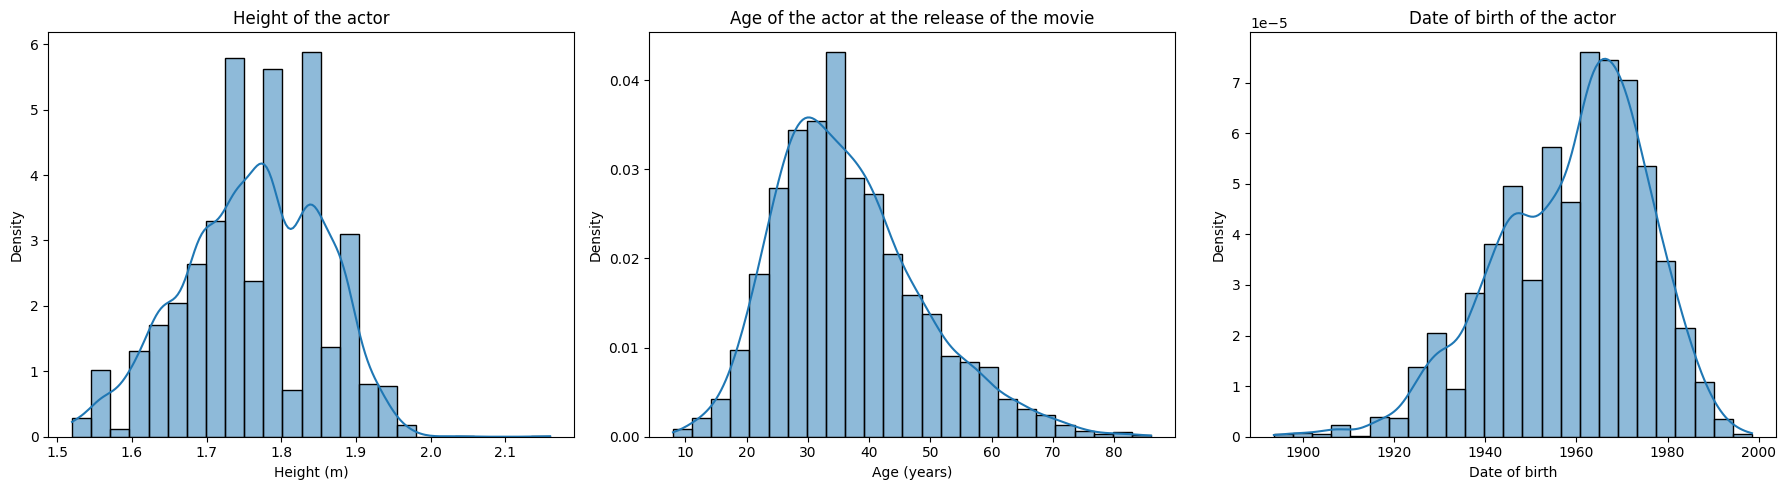

In [58]:
histogram_actors(lead_actors_data_on_subset_movie)

Let's now explore the categorical data.

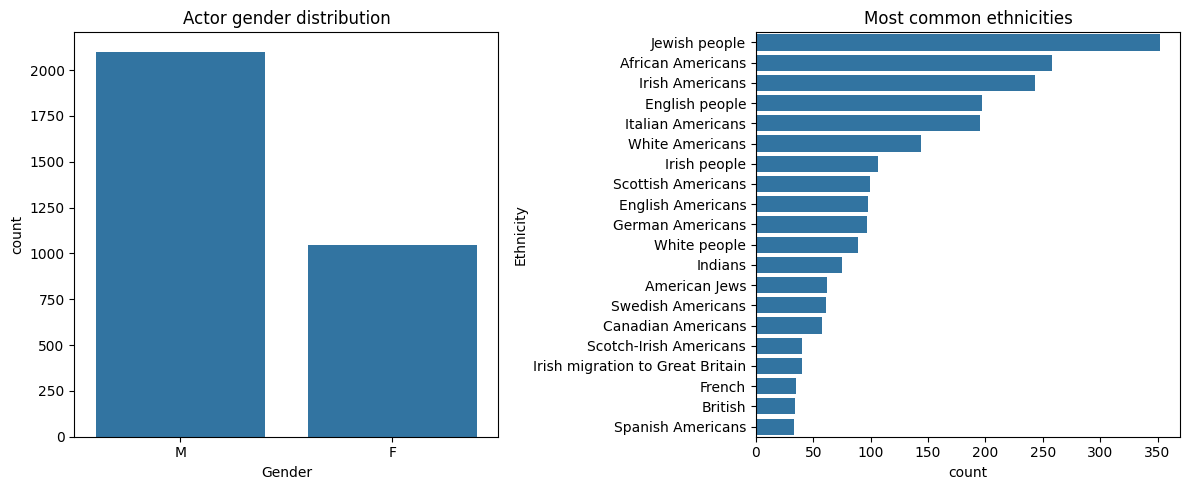

In [59]:
count_actors(lead_actors_data_on_subset_movie)

We can visualize here the correlation matrix between the attributes of the actors.

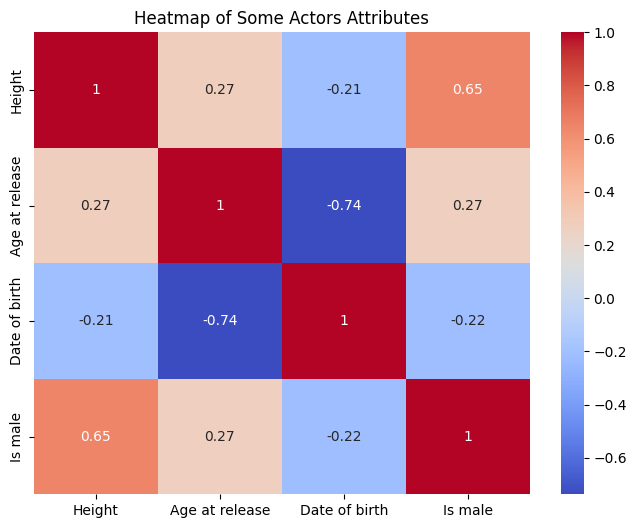

In [60]:

fig, ax = plt.subplots(figsize=(8, 6))

# Subset the data
lead_actors_for_corr = lead_actors_data_on_subset_movie[
    ['actor_height', 'actor_age_at_release', 'actor_dob', 'actor_gender']
]

# Convert gender to boolean using one-hot encoding
lead_actors_gender_dummies = pd.get_dummies(lead_actors_for_corr['actor_gender'], drop_first=False)
lead_actors_for_corr = lead_actors_for_corr.drop('actor_gender', axis=1).join(lead_actors_gender_dummies)
lead_actors_for_corr.drop('F', axis=1, inplace = True)
# Compute correlation matrix
corr_matrix = lead_actors_for_corr.corr()

# Define labels for the heatmap
label_names = ['Height', 'Age at release', 'Date of birth', 'Is male']

# Plot heatmap
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=label_names, yticklabels=label_names)
ax.set_title('Heatmap of Some Actors Attributes')
plt.show()

### Characters dataset

We now analyze the dataframe with the characters (including non-lead actors). We again start with a summary of the statistics of the numerical features.

In [61]:
characters_data_on_subset_movie.describe()

,actor_dob,actor_height,actor_age_at_release
count,8243,8243.000000,8243.000000
mean,1960-05-11 02:29:53.230619968,1.757668,37.252942
min,1893-02-10 00:00:00,1.510000,5.000000
25%,1949-05-24 00:00:00,1.690000,28.000000
50%,1963-02-17 00:00:00,1.760000,35.000000
75%,1971-09-08 00:00:00,1.830000,45.000000
max,2000-10-31 00:00:00,2.200000,94.000000
std,NaN,0.097180,13.229947


Let's do some plots to visualize better. As it is very similar as the plots from the lead actors dataset, we will compare our plots with the ones from this dataset.

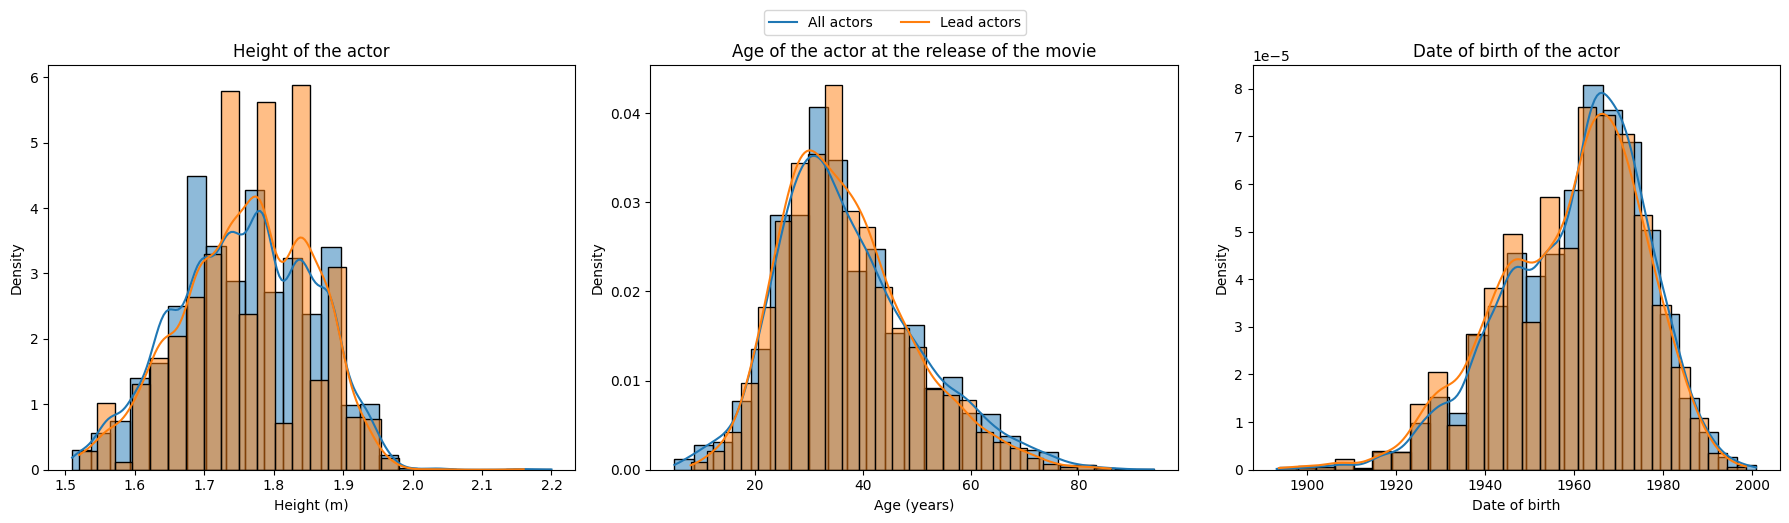

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

histogram_actors(characters_data_on_subset_movie, axes=axes)
histogram_actors(lead_actors_data_on_subset_movie, axes=axes)

fig.tight_layout()
fig.legend(["All actors", "Lead actors"], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)


Now we quickly focus only on the lead actors and visualize the height, age and date of birth of male vs. female actors.

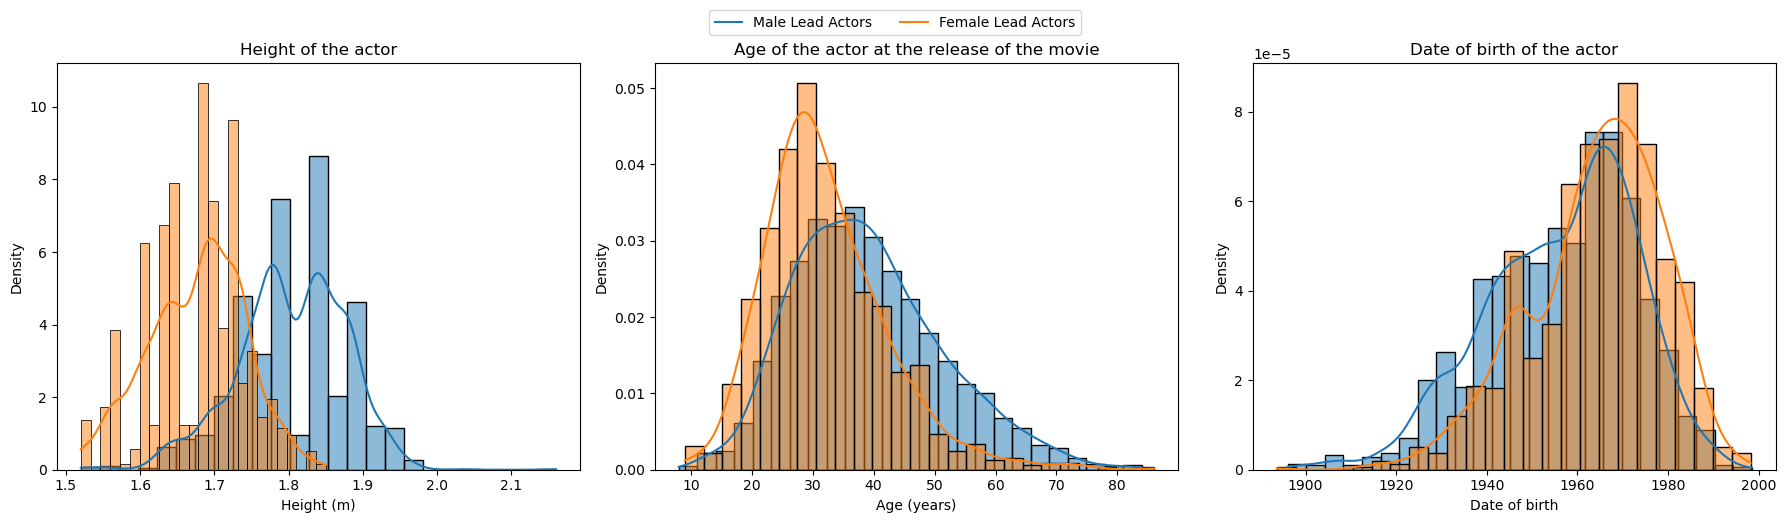

In [256]:
male = lead_actors_data_on_subset_movie['actor_gender'] == 'M'

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
histogram_actors(lead_actors_data_on_subset_movie[male], axes=axes)
histogram_actors(lead_actors_data_on_subset_movie[~male], axes=axes)

fig.tight_layout()
fig.legend(["Male Lead Actors", "Female Lead Actors"], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

We can see that the male actors are taller and slightly older.

Finally we compare the gender distribution between all actors and only lead actors.

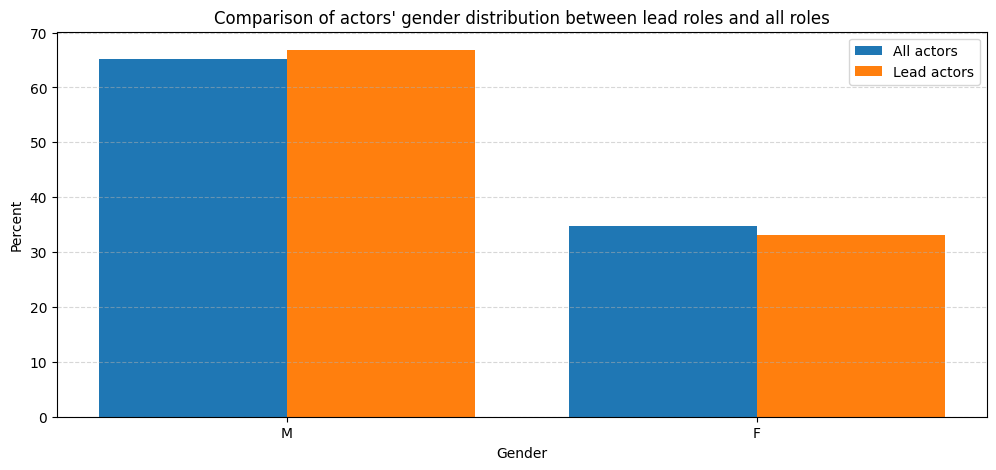

In [63]:
fig, ax = plt.subplots(figsize = (12, 5))
width = 0.4

# Compute the distribution
gender_dist_all = characters_data_on_subset_movie['actor_gender'].value_counts(normalize=True) * 100
gender_dist_lead = lead_actors_data_on_subset_movie['actor_gender'].value_counts(normalize=True) * 100
labels = list(gender_dist_all.keys())
# Make the bar plots
bar_all = ax.bar(labels, gender_dist_all, -width, label="All actors", align='edge')
bar_lead = ax.bar(labels, gender_dist_lead, width, label="Lead actors", align='edge')

ax.set_title("Comparison of actors' gender distribution between lead roles and all roles")
ax.set_xlabel("Gender")
ax.set_ylabel("Percent")
plt.grid(axis='y', linestyle='--', alpha=0.5)

ax.legend()
plt.show()

### Movies dataset 

Let's now analyze our movies dataset. We will start with a summary of the statistics of the numerical features.

In [64]:
movie_data_completed = full_movie_data_preprocessed.copy()
movie_data_completed.describe()

,wikipedia_movie_id,movie_release_date,box_office_revenue,runtime,averageRating,numVotes,release_year,adjusted_box_office
count,3.494000e+03,3494,3.494000e+03,3494.000000,3494.000000,3.494000e+03,3494.000000,3.494000e+03
mean,7.232834e+06,1995-05-03 14:46:54.882656,4.166810e+07,107.590355,6.268460,6.083259e+04,1994.812536,6.761822e+07
min,3.746000e+03,1958-01-29 00:00:00,1.000000e+00,61.000000,1.700000,5.080000e+02,1958.000000,1.426329e+00
25%,1.077141e+06,1987-10-12 06:00:00,4.105368e+06,95.000000,5.700000,5.919250e+03,1987.000000,6.783987e+06
50%,3.058664e+06,1996-10-11 00:00:00,1.470875e+07,104.000000,6.400000,1.856600e+04,1996.000000,2.413759e+07
75%,9.938000e+06,2005-06-10 00:00:00,4.099917e+07,116.000000,6.900000,5.946375e+04,2005.000000,7.047623e+07
max,3.681425e+07,2012-11-02 00:00:00,9.634204e+08,198.000000,8.800000,2.328816e+06,2012.000000,2.998235e+09
std,8.934903e+06,NaN,7.976602e+07,18.188081,0.972229,1.305237e+05,11.857733,1.346147e+08


Let's print their distributions (except for the wikipedia id):

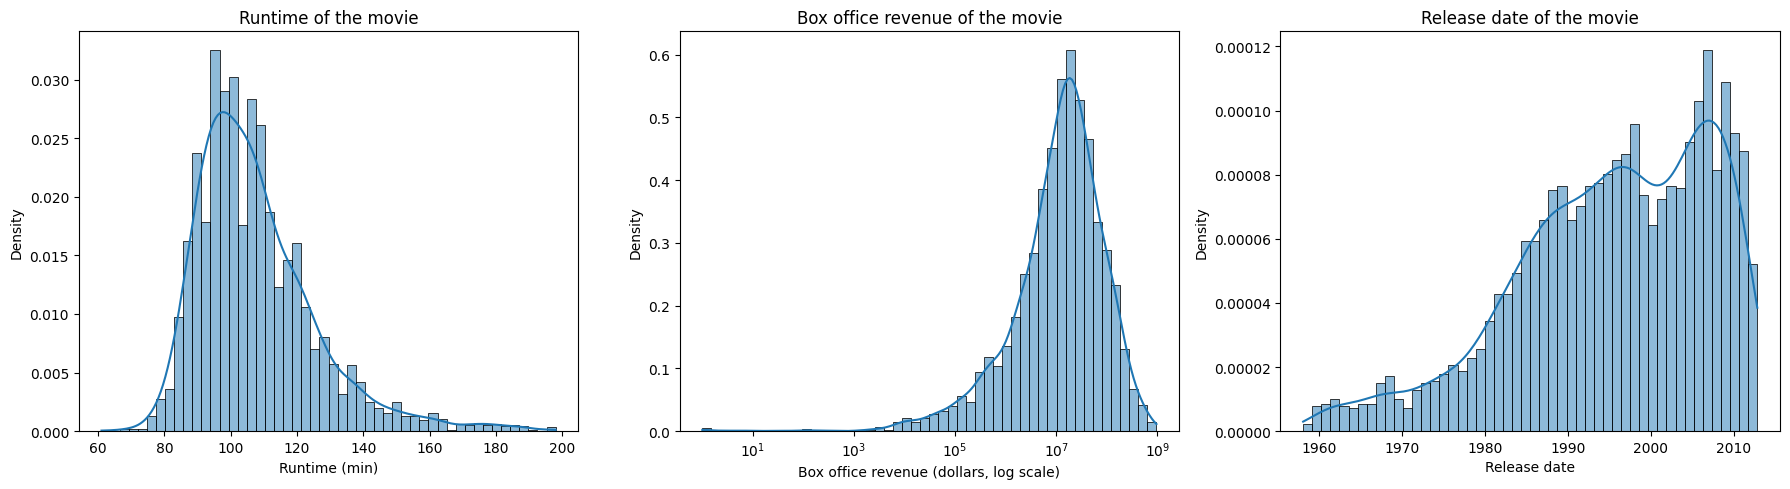

In [65]:
histogram_movies(movie_data_completed)

Let's now look at the ratings and number of votes per movie.

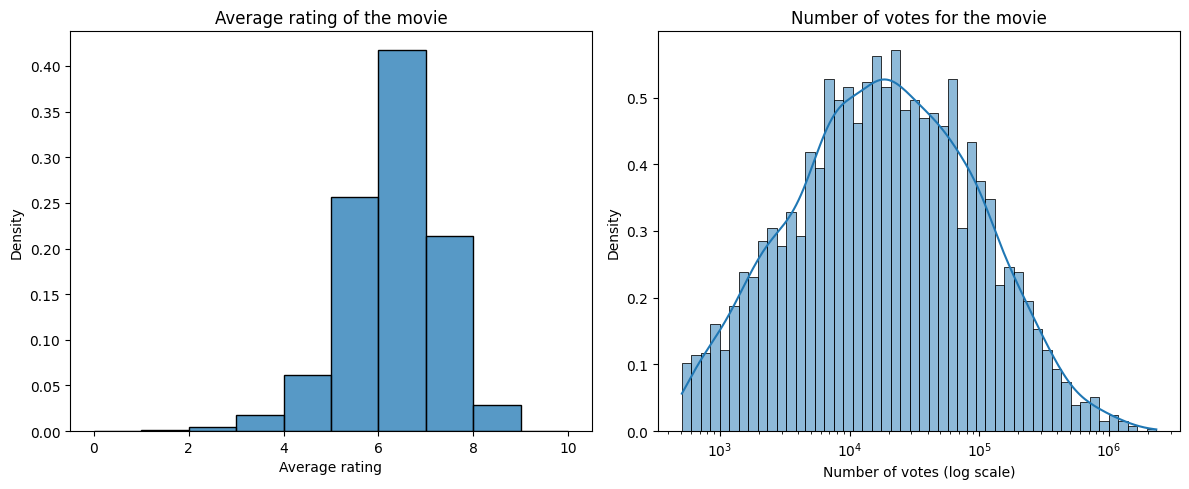

In [66]:
histogram_movie_ratings(movie_data_completed)

We can now have a look at the categorical features:

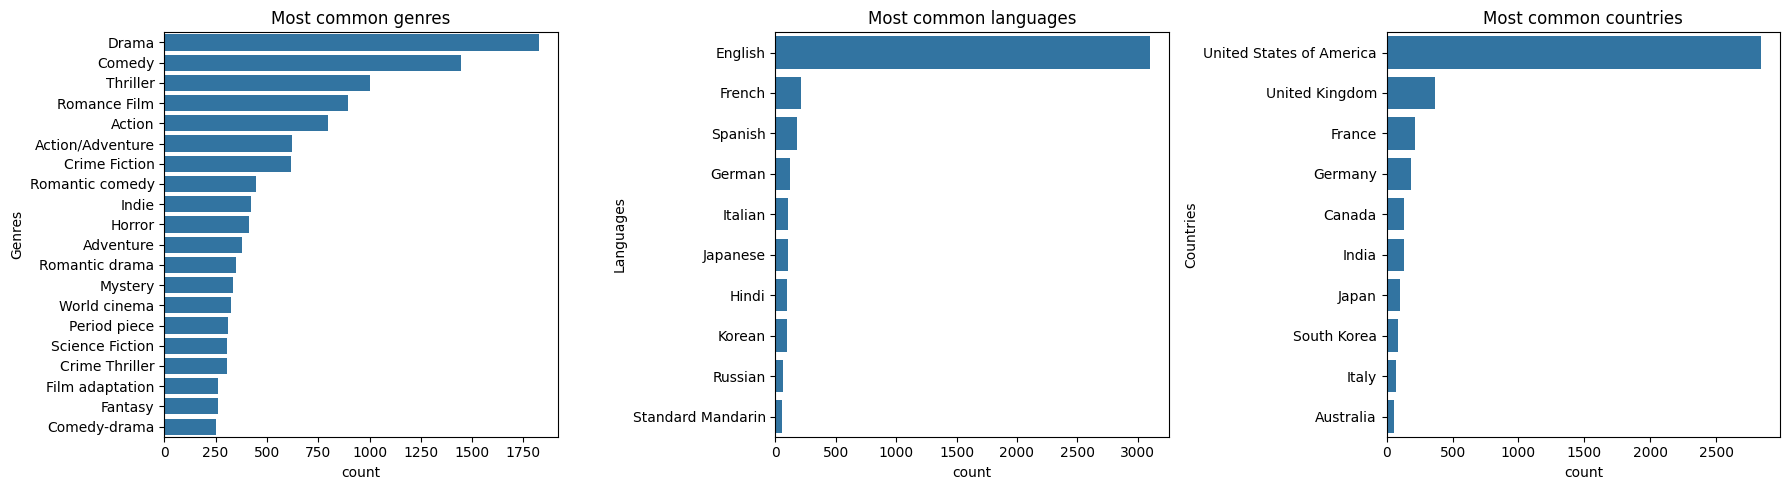

In [67]:
count_movies(movie_data_completed)

As we can expect, the English language and United States of America clearly dominate the movie industry.

Going a little further, we can visualize the total box office revenue (adjusted) for the top 10 genres.

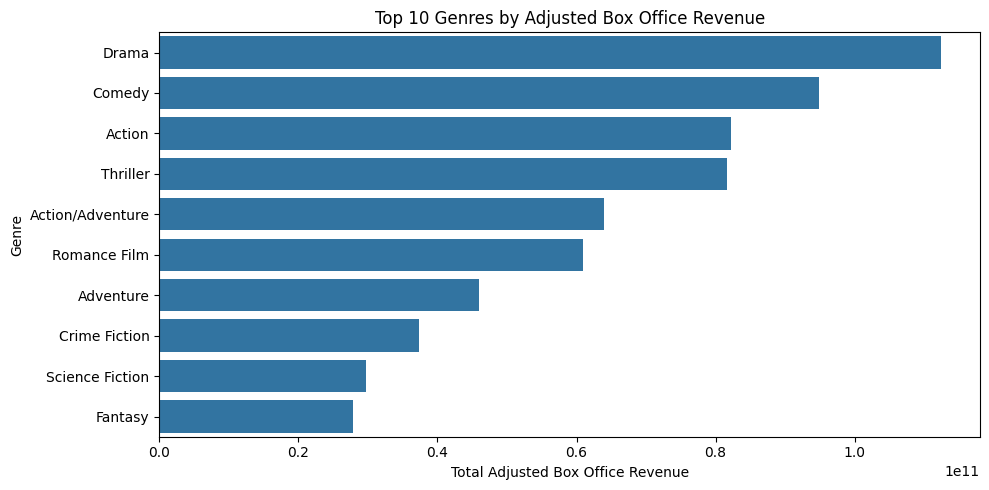

In [68]:
box_office_by_genre_barplot(movie_data_completed)

This already gives us some informations: drama and comedy are the genres that have the most commercial success (in addition of being the two most common genres as we showed before). This is important to consider if we want to maximize the box office!

## Regression analysis
Let's see if we can predict the box office from the average rating and the number of votes!

In [69]:
# Take the log of the box office revenue and of numVotes
full_movie_data_preprocessed["log_box_office_revenue"] = np.log(full_movie_data_preprocessed["box_office_revenue"])
full_movie_data_preprocessed["log_numVotes"] = np.log(full_movie_data_preprocessed["numVotes"])

In [70]:
# Define the model formula
mod = smf.ols(formula='log_box_office_revenue ~ averageRating + log_numVotes', data=full_movie_data_preprocessed)

# Set a random seed for reproducibility
np.random.seed(0)

# Fit the model
res = mod.fit()

# Print the summary
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     log_box_office_revenue   R-squared:                       0.406
Model:                                OLS   Adj. R-squared:                  0.405
Method:                     Least Squares   F-statistic:                     1192.
Date:                    Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                            18:09:37   Log-Likelihood:                -6703.0
No. Observations:                    3494   AIC:                         1.341e+04
Df Residuals:                        3491   BIC:                         1.343e+04
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Interc

Interesting, there is a strong positive corelation between the number of votes and the box office revenue. Let's visualize this in a scatter plot!

<Axes: xlabel='averageRating', ylabel='log_numVotes'>

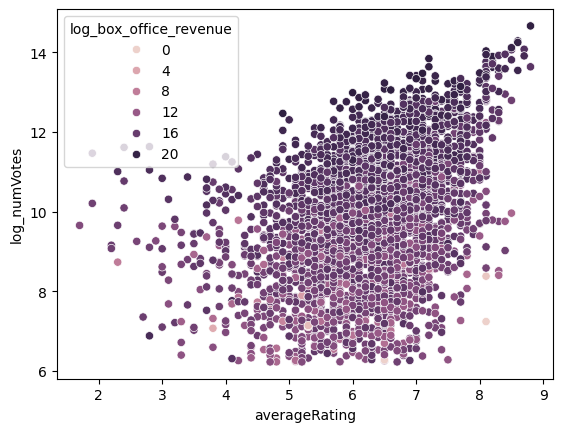

In [71]:
sns.scatterplot(data=full_movie_data_preprocessed, x='averageRating', y='log_numVotes', hue='log_box_office_revenue')

### Inflation Box Office Revenue
We established that the USA is by far the number 1 filmmaker, as such, adjusted box office is indexed on US inflation and given in dollars. We want to see how old movies compare to new movies when levelling the playing field. This can be done through scatterplots of both the average box office return, adjusted for inflation, and the average box office of the ten highest grossing movies in a given year. This is because we may not have information about very old obscure and unsuccessfull movies. By adjusting for inflation, we ensure that our data is not unfairly biaised towards recent releases. 

We start by comparing the mean box office results adjusted/not adjusted for inflation through time.

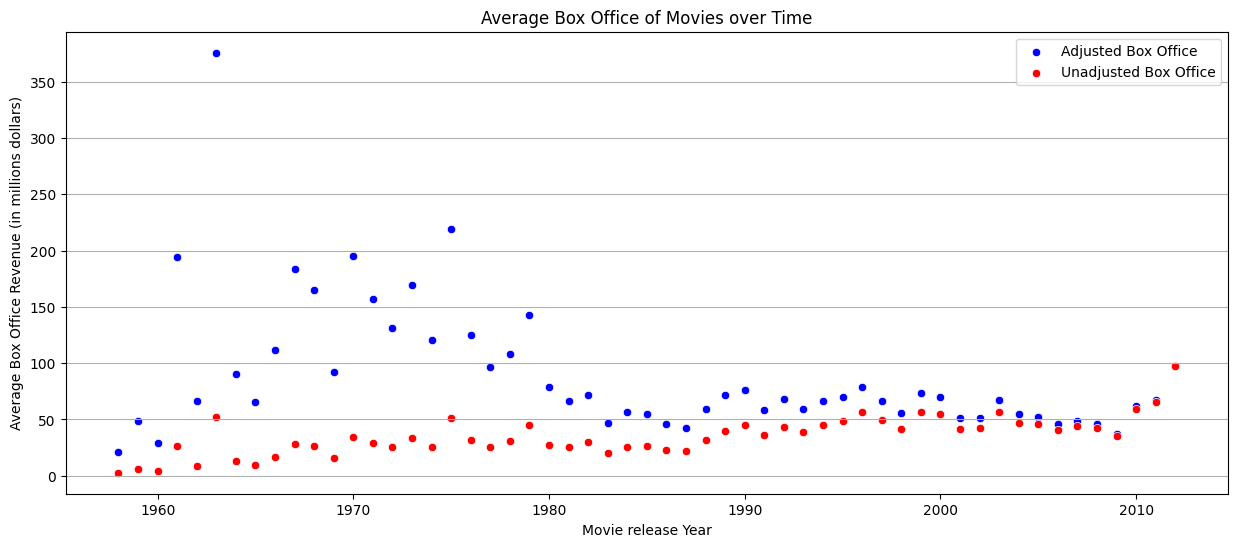

In [72]:
inflation_plots(movie_data_completed)

Interesting, it seems like older movies performed similarily or even better than modern movies when adjusted for inflation.
It could be that we only have data on more successful old movies, and that those that did not perform well were lost to time.
As such, let us test the average box office revenue for the 10 highest grossing movies each year.

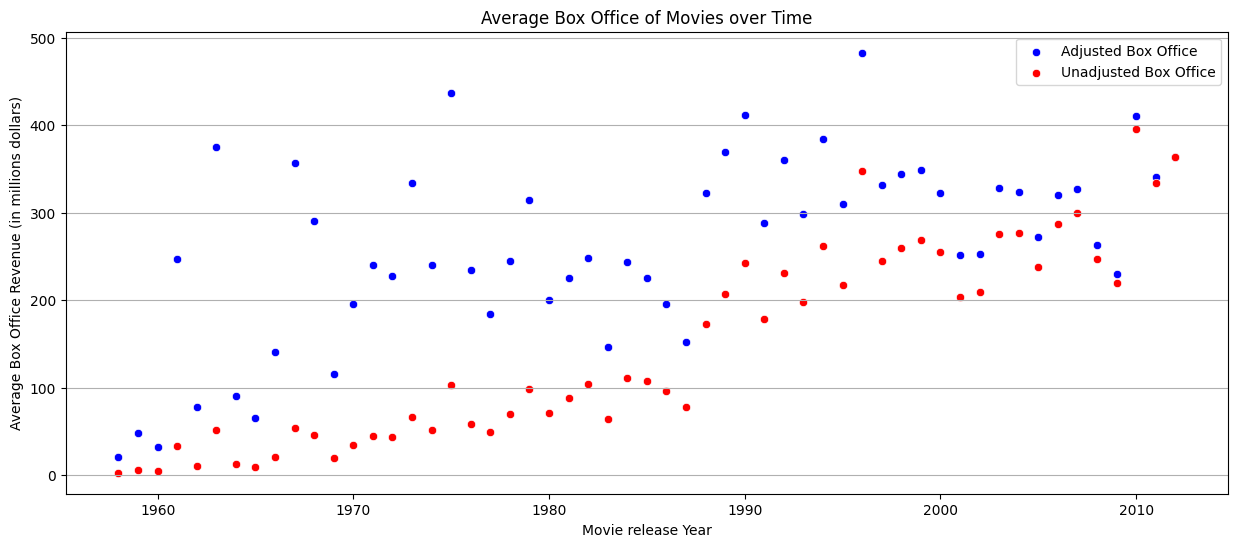

In [73]:
inflation_plots(movie_data_completed, True)

It seems that even adjusted for inflation, box office revenue of the biggest blockbusters are on the rise.

### Low vs. high rating/revenue analysis

Now let's see the difference between low and high rated movies as well as between movies with low and high box office revenues! We will split the dataset by using the median such that we get equals subsets for comparison.

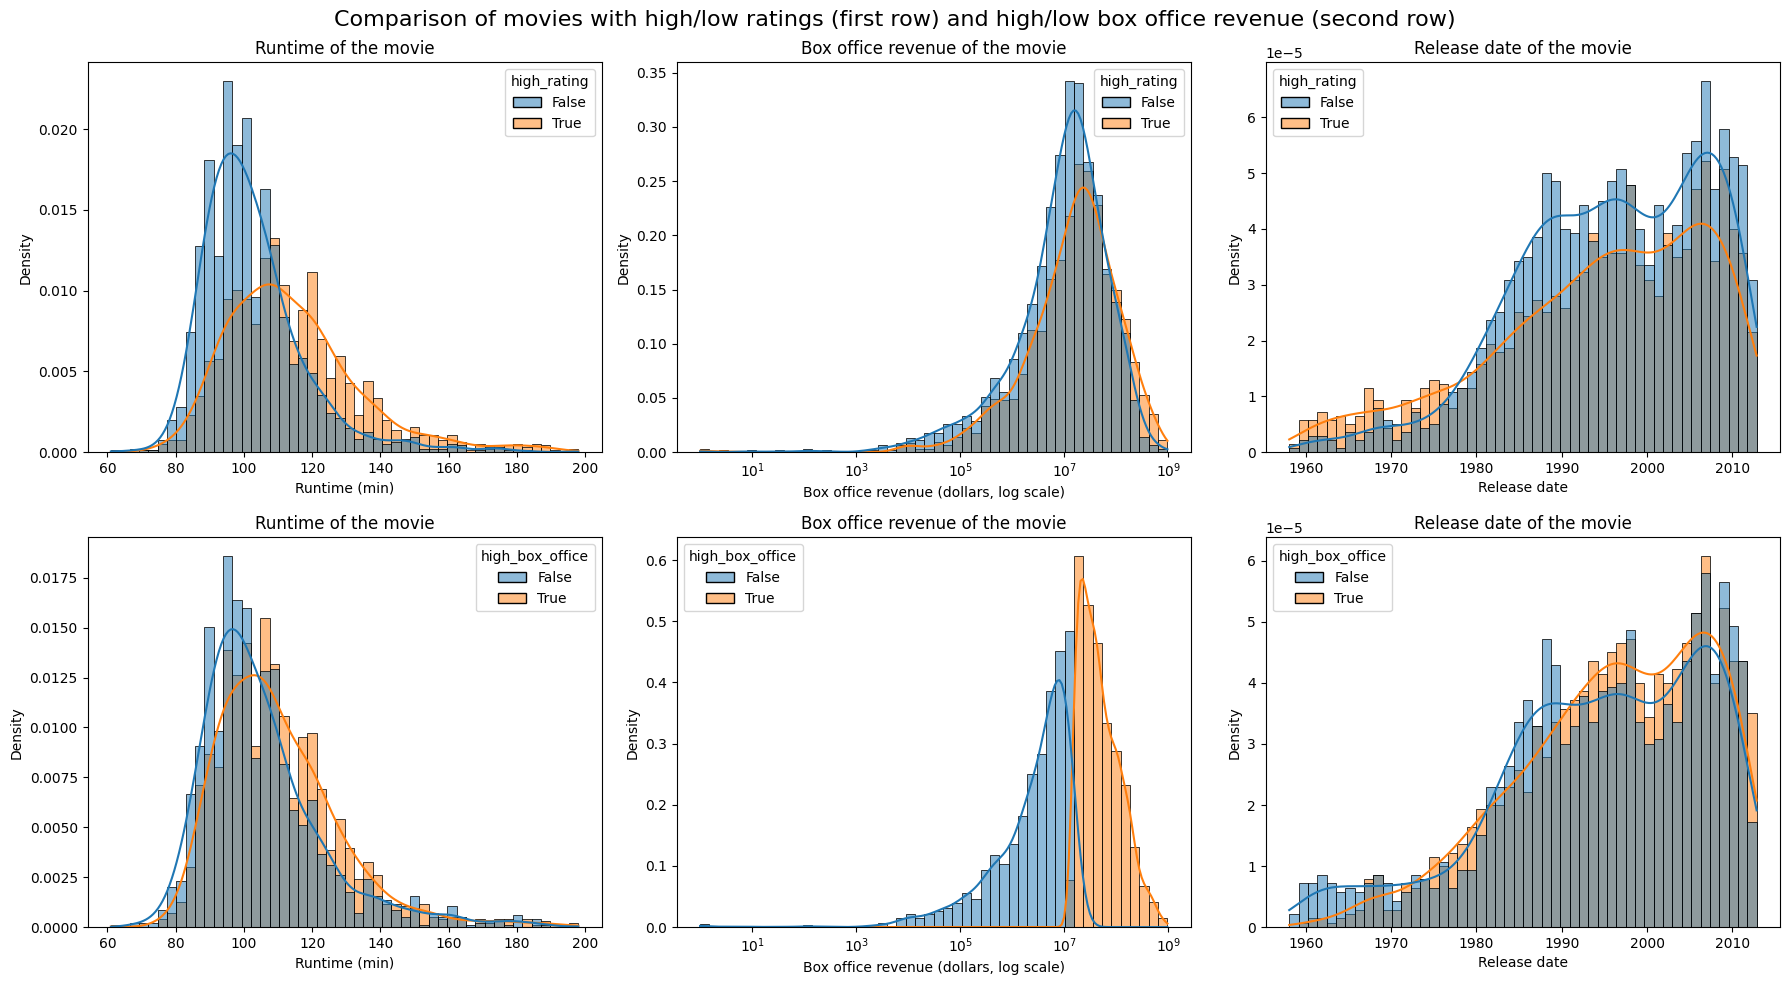

In [74]:
# Split the movies by the median rating and median box office revenue
median_rating = full_movie_data_preprocessed['averageRating'].median()
median_box_office = full_movie_data_preprocessed['box_office_revenue'].median()

# Add a column to the DataFrame to indicate if the movie has a high rating/box office revenue
full_movie_data_preprocessed['high_rating'] = full_movie_data_preprocessed['averageRating'] > median_rating
full_movie_data_preprocessed['high_box_office'] = full_movie_data_preprocessed['box_office_revenue'] > median_box_office

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histogram_movies(full_movie_data_preprocessed, hue="high_rating", axes=axes[0])
histogram_movies(full_movie_data_preprocessed, hue="high_box_office", axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()


First, we see that the box office was correctly split by low/high revenue (see second plot of the second row).

Futhermore, we can observe a slight difference in the runtime distribution between high and low rated/revenue movies.
Let's verify this observation with as statistical test.
From the graph we can see that the data follows a normal distribution.
Therefore, we will make the following null hypothesis that the distributions underlying the samples are uncorrelated and normally distributed.

In [75]:

high_rating = full_movie_data_preprocessed['high_rating']
high_box_office = full_movie_data_preprocessed['high_box_office']

runtime = full_movie_data_preprocessed['runtime']

runtime_high_rating_corr = stats.pearsonr(runtime, high_rating)
runtime_high_box_office_corr = stats.pearsonr(runtime, high_box_office)

print(f"Correlation between runtime and high rating: {runtime_high_rating_corr[0]:.3f} (p-value: {runtime_high_rating_corr[1]:.3f})")
print(f"Correlation between runtime and high box office revenue: {runtime_high_box_office_corr[0]:.3f} (p-value: {runtime_high_box_office_corr[1]:.3f})")

Correlation between runtime and high rating: 0.315 (p-value: 0.000)
Correlation between runtime and high box office revenue: 0.128 (p-value: 0.000)


Here our alternative hypothesis is: the correlation is non zero. So our null hypothesis is : the correlation is zero.
Since we have that our p-value < 0.05, we can reject the null hypothesis at 5% significance level and conclude that our high rating and box office revenue are likely correlated with runtime respectively with factors of 0.316 and 0.129.

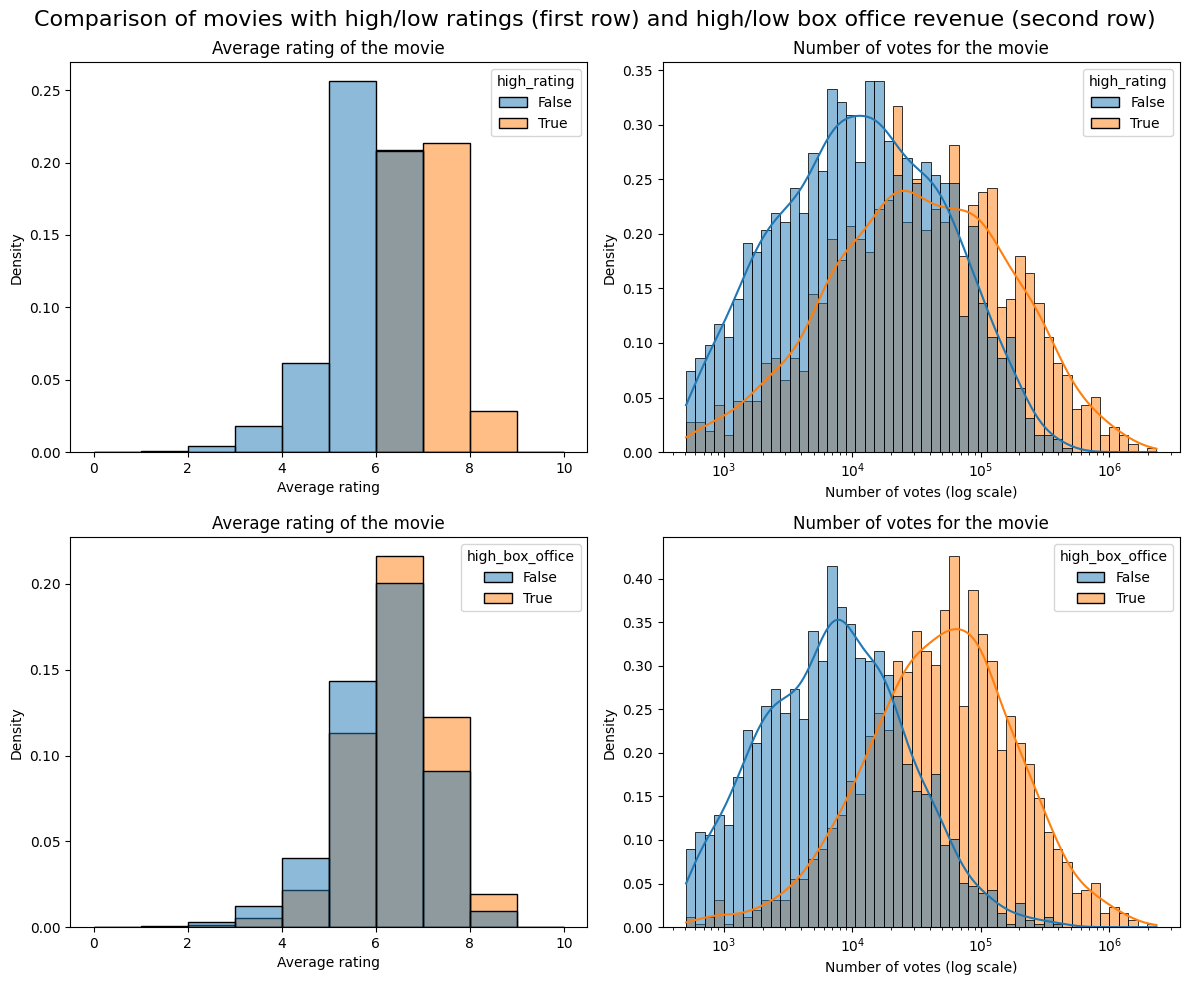

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

histogram_movie_ratings(full_movie_data_preprocessed, hue="high_rating", axes=axes[0])
histogram_movie_ratings(full_movie_data_preprocessed, hue="high_box_office", axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

Again, we see that the data was correctly split by high and low ratings.

Futhermore, we can observe that there is difference in the number of votes for high and low rated/revenue movies.
Let's verify this observation with as statistical test.
From the graph we can see that the data follows a normal distribution.
Therefore, we will make the following null hypothesis that the distributions underlying the samples are uncorrelated and normally distributed.

In [77]:
votes = full_movie_data_preprocessed['numVotes']
log_votes = np.log(votes)

log_votes_high_rating_corr = stats.pearsonr(log_votes, high_rating)
log_votes_high_box_office_corr = stats.pearsonr(log_votes, high_box_office)

print(f"Correlation between log votes and high rating: {log_votes_high_rating_corr[0]:.3f} (p-value: {log_votes_high_rating_corr[1]:.3f})")
print(f"Correlation between log votes and high box office revenue: {log_votes_high_box_office_corr[0]:.3f} (p-value: {log_votes_high_box_office_corr[1]:.3f})")

Correlation between log votes and high rating: 0.323 (p-value: 0.000)
Correlation between log votes and high box office revenue: 0.586 (p-value: 0.000)


Here our alternative hypothesis is: the correlation is non zero. So our null hypothesis is : the correlation is zero.
Since we have that our p-value < 0.05, we can reject the null hypothesis at 5% significance level and conclude that our high rating and box office revenue are likely correlated with log votes respectively with factors of 0.323 and 0.586.

Now, let's look at the categorical features.

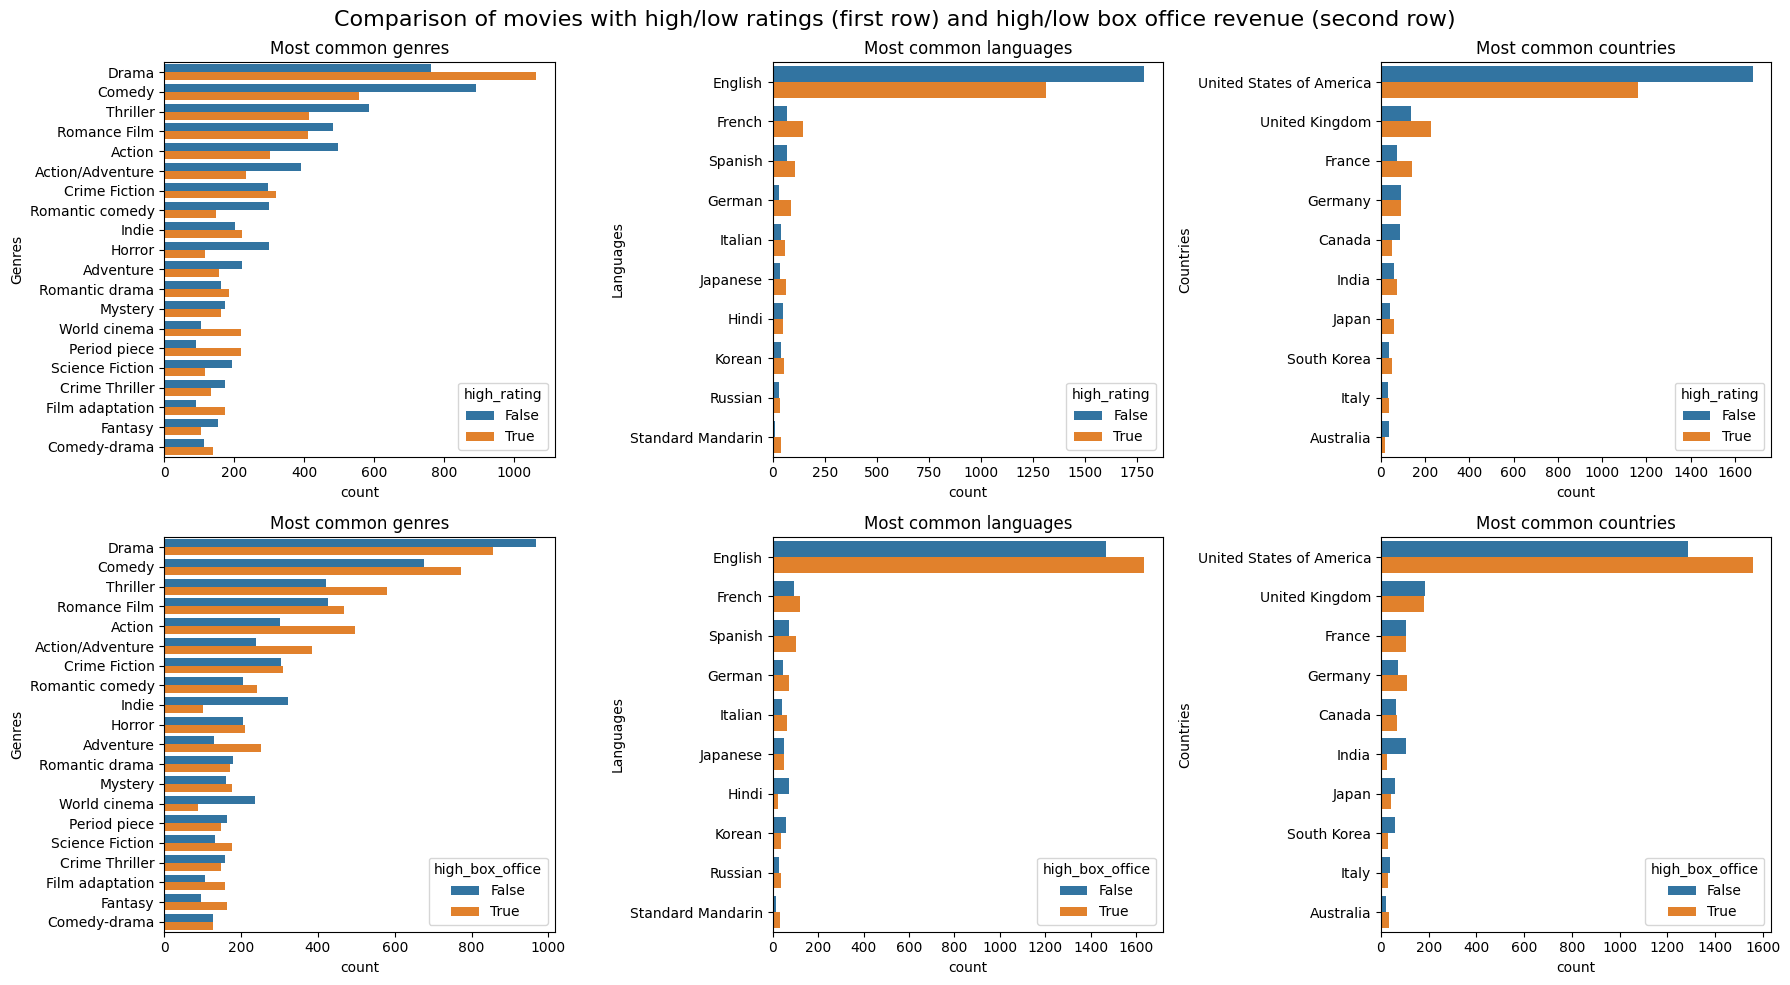

In [78]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

count_movies(full_movie_data_preprocessed, hue="high_rating", axes=axes[0])
count_movies(full_movie_data_preprocessed, hue="high_box_office", axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

We can see that there are more higher rated dramas than lower rated one, but there are less high box office revenue dramas than high revenue one.

Futhermore, we see that there are more lower rated comedies but they usually have higher box office revenues.

Now let's have a look at the difference in lead actors' attributes between high and low rating movies.

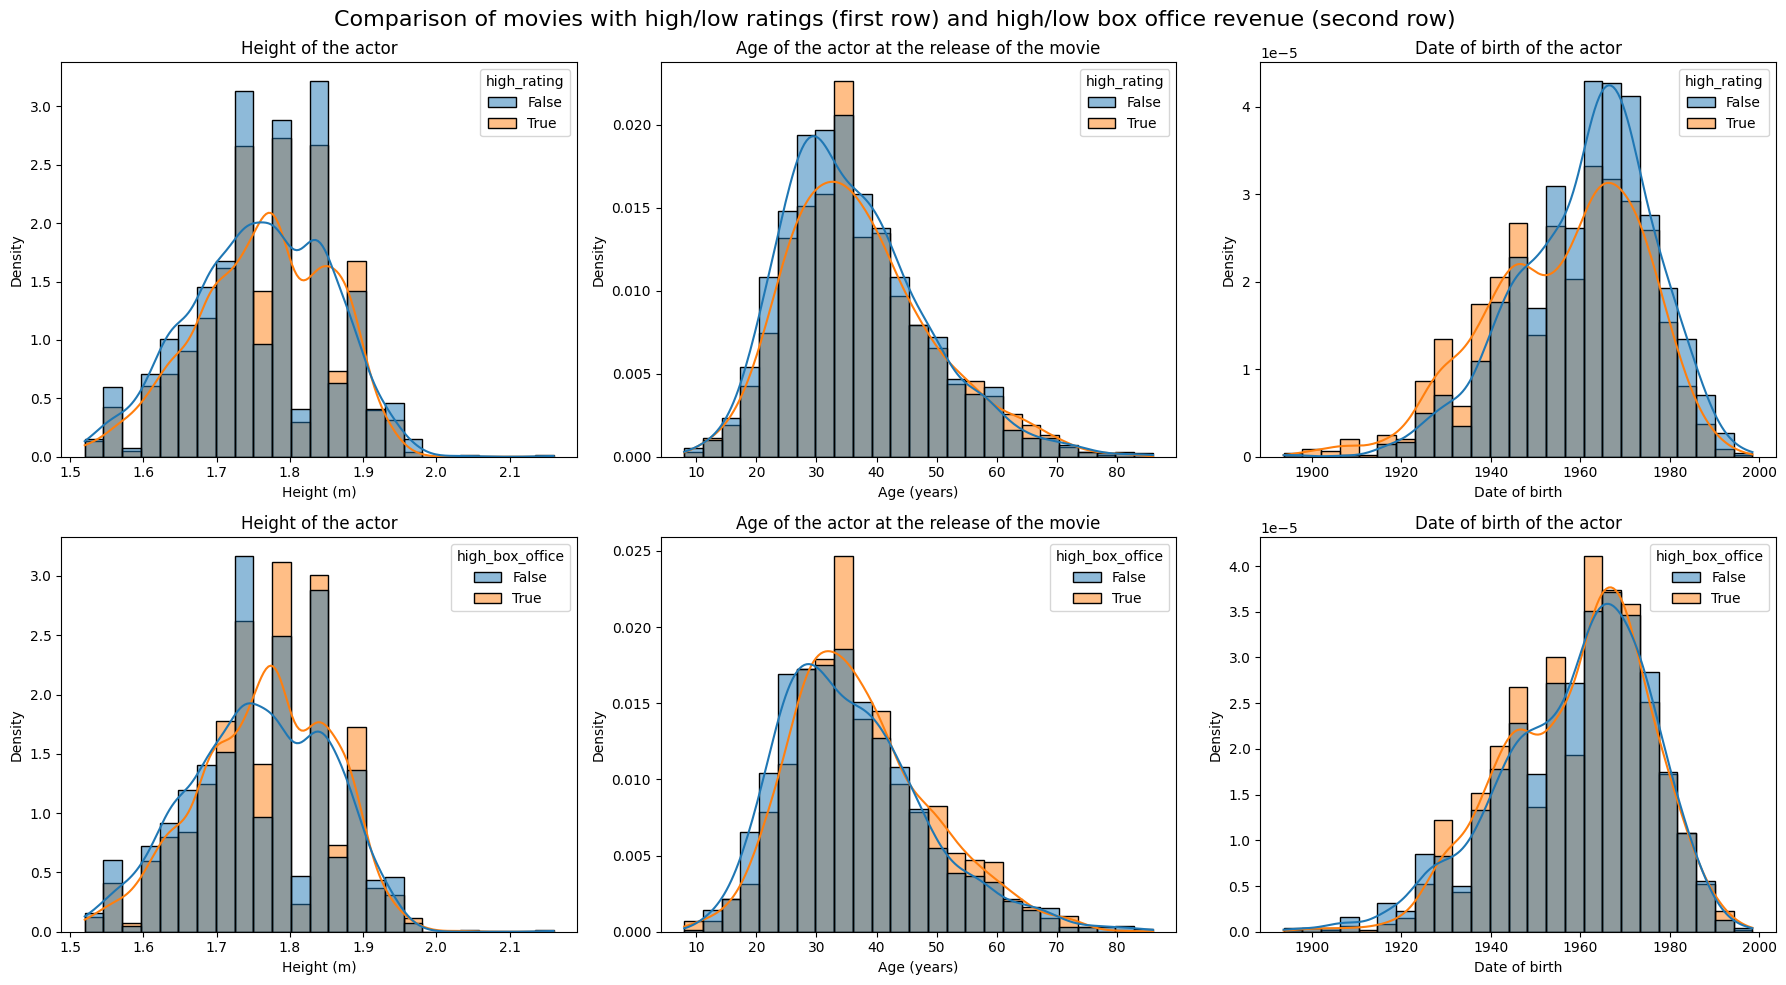

In [79]:
# Merge the movie data with the lead actors data
merged = pd.merge(full_movie_data_preprocessed, lead_actors_data_on_subset_movie, left_on='freebase_movie_id', right_on='freebase_movie_id')

# Split the movies by the median rating and median box office revenue
median_rating = merged['averageRating'].median()
median_box_office = merged['box_office_revenue'].median()

# Add a column to the DataFrame to indicate if the movie has a high rating/box office revenue
merged['high_rating'] = merged['averageRating'] > median_rating
merged['high_box_office'] = merged['box_office_revenue'] > median_box_office

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histogram_actors(merged, hue='high_rating', axes=axes[0])
histogram_actors(merged, hue='high_box_office', axes=axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

Not much of a difference here, let's look at the categorical attributes.

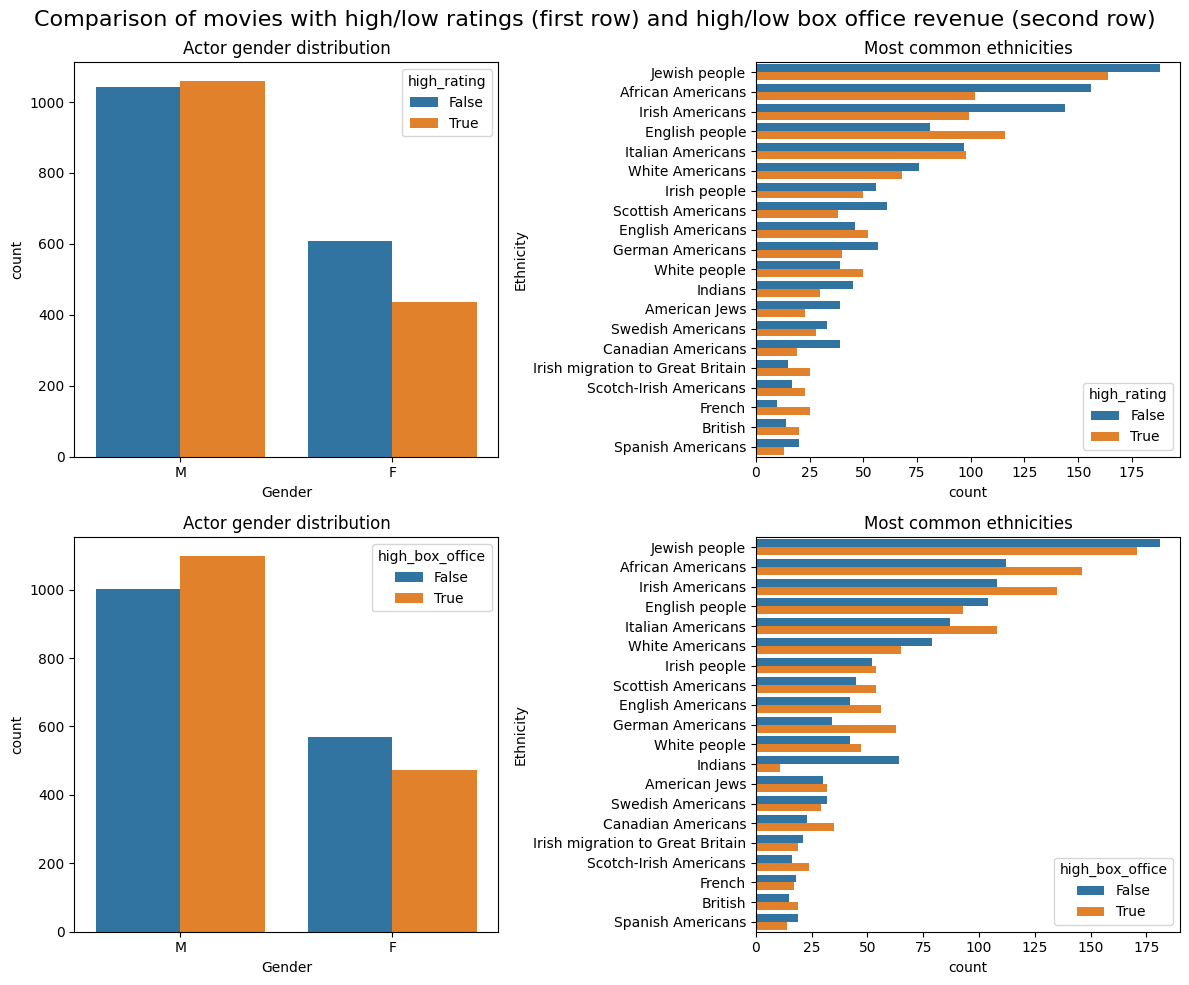

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

count_actors(merged, "high_rating", axes[0])
count_actors(merged, "high_box_office", axes[1])

fig.suptitle("Comparison of movies with high/low ratings (first row) and high/low box office revenue (second row)", fontsize=16)
fig.tight_layout()

We can see that there are more men in higher rated/revenue movies as in lower rated/revenue movies.
Whereas, it's the opposite for women.
Let's verify this with statistical test!
The null hypothesis is that the frequencies between high/low ratings (and revenues) are independent.

In [81]:
high_rating = merged['high_rating']
high_box_office = merged['high_box_office']

gender = merged['actor_gender'].apply(lambda g: g == 'M')

gender_rating_count = stats.contingency.crosstab(gender, high_rating)
print("Count the number of women/men (rows) with high/low ratings (columns):")
print(gender_rating_count.count)
print()

gender_box_office_count = stats.contingency.crosstab(gender, high_box_office)
print("Count the number of women/men (rows) with high/low box office revenue (columns):")
print(gender_box_office_count.count)

Count the number of women/men (rows) with high/low ratings (columns):
[[ 608  436]
 [1042 1059]]

Count the number of women/men (rows) with high/low box office revenue (columns):
[[ 570  474]
 [1003 1098]]


In [82]:
gender_rating_chi2 = stats.chi2_contingency(gender_rating_count)
gender_box_office_chi2 = stats.chi2_contingency(gender_box_office_count)

# Print the p-values
print(f"Chi-squared test p-value for gender and high rating correlation: {gender_rating_chi2[1]:.3f}")
print(f"Chi-squared test p-value for gender and high box office revenue correlation: {gender_box_office_chi2[1]:.3f}")

Chi-squared test p-value for gender and high rating correlation: 0.000
Chi-squared test p-value for gender and high box office revenue correlation: 0.004


In both cases we can reject the null hypothesis by a significance level of 0.05, i.e. we reject the hypothesis that gender and high rating are independent and that gender and high box office are independent.

Futhermore, we can see that there are more African Americans in lower rated movies as in high rated movies.
Whereas, it's the opposite for English People.

Interestingly, we see that there are more African Americans in movies with high revenue as in lower box office revenue movies.

### Matching

We want to explore the data even furhter using propensity score matching.
Lets to do it!

First we start by extracting all categorical and numerical features of our dataset.

In [83]:
categorical, columns = extract_categorical_features(merged)
numerical = extract_numerical_features(merged)

Because we are going match on the propensity score computed by linear regression, we want to normalize our numerical features.

In [84]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

numerical_standardized = scalar.fit_transform(numerical)
numerical_standardized = pd.DataFrame(numerical_standardized, columns=numerical.columns)

data = pd.concat([numerical_standardized, categorical], axis=1)

Now we are ready to start matching. We will do the matching for each category of each categorical feature twice.
Once to compute the average treatment effect (ATE) of the category on the average rating and once to compute the ATE on the log adjusted box office revenue.

In [85]:
rating_effects = ate_categorical_values(data, categorical.columns, 'averageRating', numerical['averageRating'])
revenue_effects = ate_categorical_values(data, categorical.columns, 'log_adjusted_box_office', numerical['log_adjusted_box_office'])

In [241]:
actor_columns = list(columns['gender']) + list(columns['height']) + list(columns['age'])
actor_characteristics = revenue_effects.merge(rating_effects, on='treatment').loc[actor_columns, ['ATE_x', 'ATE_y']]
actor_characteristics.columns = ['ATE on average rating', 'ATE on log adjusted box office revenue']
actor_characteristics.index = list(map(lambda index: index.replace('actor_', '').replace('_', ' ').capitalize(), actor_characteristics.index))
actor_characteristics

,ATE on average rating,ATE on log adjusted box office revenue
Gender,-0.0689,0.0124
"Height [1.52,1.73]",-0.0382,-0.0058
"Height [1.73,1.8]",0.0578,-0.0158
"Height [1.8,2.16]",-0.0212,-0.0175
"Age at release [8.0,26.0]",0.0346,-0.0055
"Age at release [26.0,30.0]",0.0479,-0.0148
"Age at release [30.0,35.0]",0.0386,-0.0285
"Age at release [35.0,40.0]",-0.0799,-0.0015
"Age at release [40.0,48.0]",-0.0873,-0.0041
"Age at release [48.0,86.0]",-0.0309,-0.0434


We can see that the actors characteristics (gender, height and age at movie release) don't have any significant effect on the average rating and box office revenue.

Lets now visualize the ate for each language, country and genre.

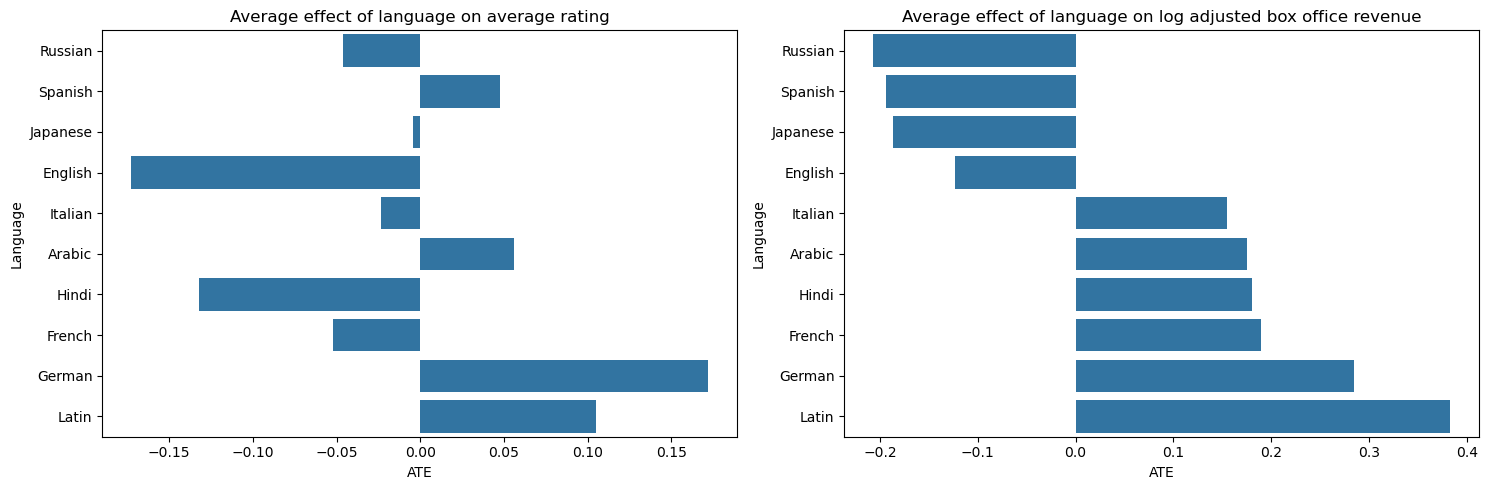

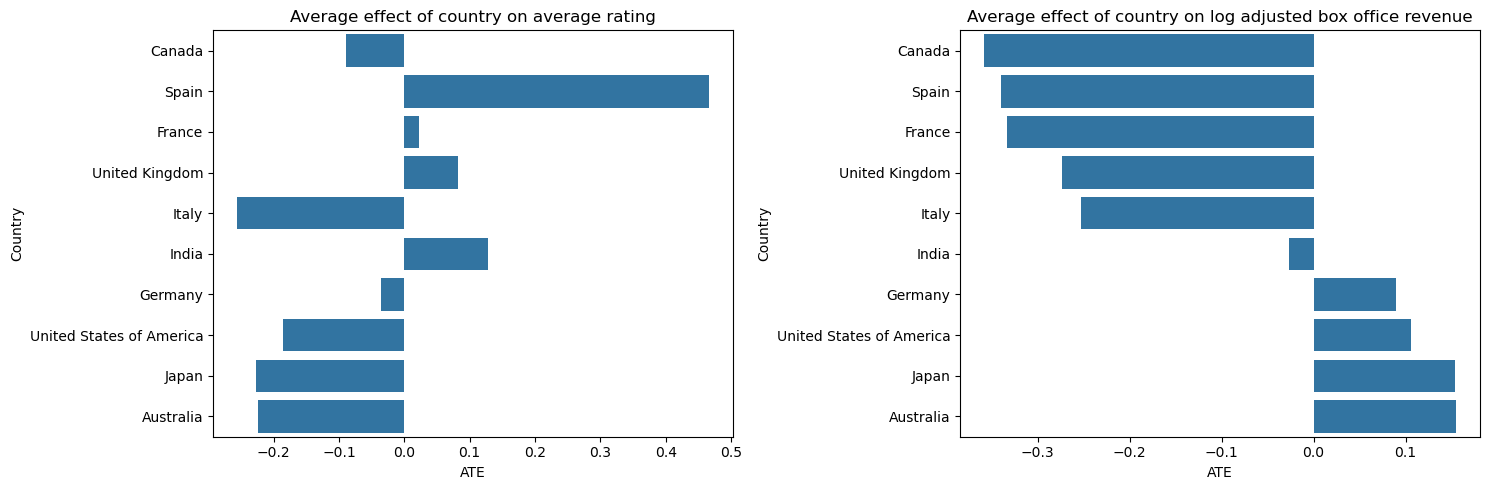

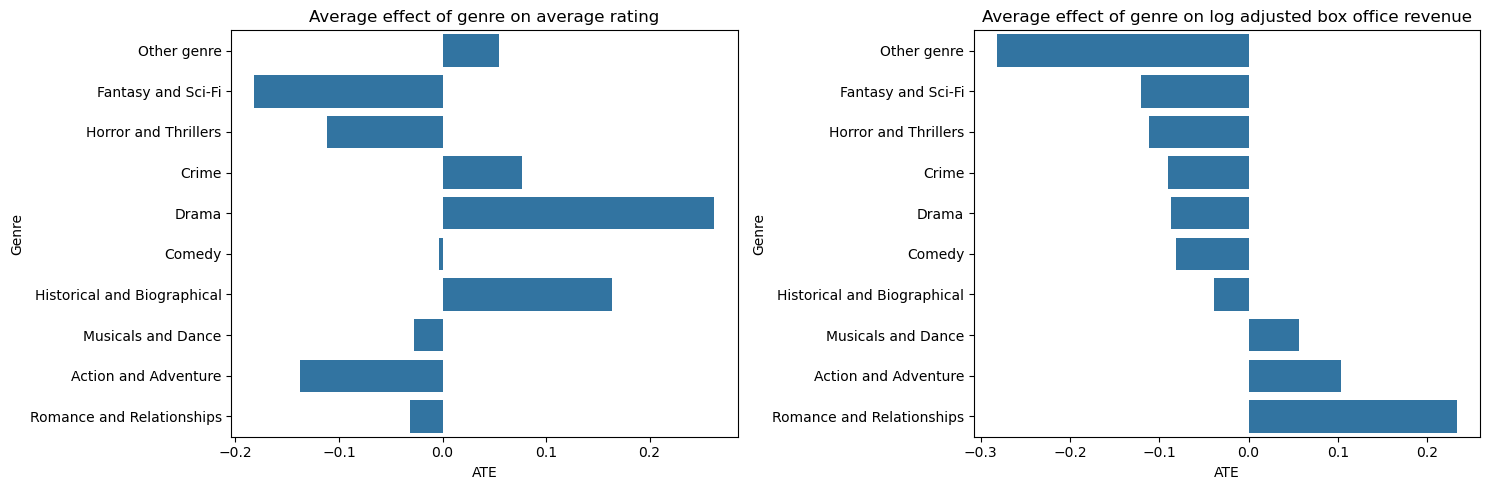

In [248]:
ate_barplot(rating_effects.loc[columns['languages']], revenue_effects.loc[columns['languages']], 'Language')
ate_barplot(rating_effects.loc[columns['countries']], revenue_effects.loc[columns['countries']], 'Country')
ate_barplot(rating_effects.loc[columns['genres']], revenue_effects.loc[columns['genres']], 'Genre')

This is quite interesting!
Movies from Spain have on average 0.6 rating points more than movies not produces in Spain!
Also, we can see that while Drama's have on average 0.3 more rating points as non Drama movies, their adjusted log box office revenue is on average lower then non Drama movies.

## Predicting the rating of a movie

After conducting our analysis, we can take it a step further by predicting the rating of a movie. To do this, we'll use a variety of features, including runtime, release year, genre, number of characters, mean age and mean height of actors at the time of release, the most frequent ethnicity among actors, as well as the ethnicity, height, and age of the two lead actors. All the necessary code for preprocessing, standardizing, and training the model can be found in src.model_random_forest.py file. We chose to use a Random Forest model because it yielded the best results in our tests. Instead of predicting box office revenue, we decided to focus on predicting the movie rating, as this allows us to use a broader dataset( many films were excluded when we focused solely on box office data due to missing values).

In [107]:
rating_model, rating_r2, rating_mse, X_train = random_forest_model()

Loading the data...
Preprocessing the columns of different datasets...
Ethnicity data already fetched.
Number of ages retrieved through calculation (using movie release data and actor dob): 21038
Removing NaN reduced the dataset by: 90.18%
Removing invalid actor heights reduced that dataset by 0.52%.
Removing invalid actor ages reduced that dataset by 0.06%.
Removing ethnicity labels which are uncommon reduced that dataset by 0.89%.
Merging the datasets...
Preprocessing merged dataset...
Creating subset of data...
Missing values in lead actor data:
actor_name               0.0
actor_dob                0.0
actor_gender             0.0
actor_ethnicity_label    0.0
actor_height             0.0
actor_age_at_release     0.0
dtype: float64
Missing values in lead actor data:
actor_name               0.0
actor_dob                0.0
actor_gender             0.0
actor_ethnicity_label    0.0
actor_height             0.0
actor_age_at_release     0.0
dtype: float64
Adding budget as a feature...
Co

Now that the training is done, we can have a look to the params used:

In [108]:
print("Random Forest Model Parameters:")
print(rating_model.get_params())

Random Forest Model Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Also, it could be interesting to check the feature importances:

In [109]:
# Get feature importances
feature_importances = rating_model.feature_importances_

# Create a DataFrame to show features and their importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df)

Feature Importances:
                             Feature  Importance
0                            runtime    0.162946
1                 movie_release_year    0.132153
9             mean_age_of_characters    0.078840
2                             budget    0.073283
10         mean_height_of_characters    0.072248
5   actor_age_at_release_lead_actor1    0.063578
4           actor_height_lead_actor1    0.054056
8   actor_age_at_release_lead_actor2    0.051283
7           actor_height_lead_actor2    0.044351
11              number_of_characters    0.041185
15                             Drama    0.027890
18              Horror and Thrillers    0.026771
20                       Other genre    0.015443
17       Historical and Biographical    0.014454
12              Action and Adventure    0.013770
35               Asian_most_frequent    0.012830
13                            Comedy    0.012381
14                             Crime    0.010195
21         Romance and Relationships    0.009399

Interesting! The most important features ones are:

- Runtime: Contributing 16.3% to the prediction.
- Movie Release Year: Contributing 13.2%.
- Mean Age of Characters: Contributing 7.9%.
- Budget: Contributing 7.3%.

# Conclusion

Through our deep analysis and comprehensive preprocessing, we are now better equipped to address our research questions. 

The exploratory phase has helped us evaluate the feasibility of our study and ensured the quality and size of our preprocessed dataset. Early analysis of Low vs. High subsets (e.g., high ratings vs. low ratings, high box office revenue vs. low revenue) confirms distinct patterns in genres and runtimes, suggesting these factors are significant for movie success.

Complementary datasets allowed us to determine the lead actors of each movie, opening doors to further analysis on the effect of the main cast. Our pre-processing and analysis helped us to determine that we have a substantial enough dataset of movies and lead actors with non-empty demographic and physical characteristics. Since our project is heavily centered around lead actor characteristics, this was a crucial step in determining that it is indeed feasable.

# Annex: clustering

We did some work on clusterings, that we include as an annex to this notebook as the results were not entirely conclusive for our research questions.

The goal is to cluster movie lead actors based on their demographic attributes. By identifying clusters with distinct characteristics, we aim to explore whether these groups of actors are associated with varying levels of box office revenue. This analysis will provide valuable insights into the types of lead actors that contribute to higher movie earnings.

In [2]:
from src.clustering import *

In [6]:
# We will use the 'adjusted_box_office' feature from movie_df later in the analysis
merged_actors_movies = lead_actors_data_on_subset_movie.merge(subset_movie_with_full_data_on_lead_actors, on='wikipedia_movie_id',how='inner')
merged_actors_movies.head(2)

,wikipedia_movie_id,freebase_movie_id_x,movie_release_date_x,character_name,actor_dob,actor_gender,actor_height,actor_name,actor_age_at_release,character_actor_map_id,...,languages,countries,genres,imdb_id,averageRating,numVotes,lead_actor_1,lead_actor_2,release_year,adjusted_box_office
0,975900,/m/03vyhn,2001-08-24 00:00:00,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,/m/0jys3g,...,['English'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",tt0228333,4.9,58906.0,Natasha Henstridge,Ice Cube,2001,1.731668e+07
1,156558,/m/014k4y,2001-06-27 00:00:00,Jody,1978-12-30,M,1.797,Tyrese Gibson,22.0,/m/0jtx5h,...,['English'],['United States of America'],"['Crime Fiction', 'Drama', 'Coming of age']",tt0255819,6.5,17112.0,Alexsandra Wright,Tyrese Gibson,2001,3.631424e+07


## Chose features and adjust them
We have demographic attributes of lead actors, including gender, height, age at the time of the movie's release, and ethnicity. These features will be used for clustering. Note that gender and ethnicity are categorical variables, which will be preprocessed to enable their use in K-means clustering.

In [7]:
# features we will need for clustering
features = ['actor_gender','actor_height','actor_age_at_release','actor_ethnicity_label']
# only keep features needed in clustering
cluster_df = merged_actors_movies[features]

In [8]:
cluster_df['actor_ethnicity_label'].nunique()

139

As we can see, there are 139 different ethnicities in the dataset. Since we plan to one-hot encode this variable, we will group the ethnicities into broader categories to reduce the number of features generated by one-hot encoding. The groupings were made based on what seemed logical for this task. For three ethnicities, we were unable to find a suitable category, so we placed them in the 'Other' group. We then decided to remove these entries, which collectively represented only 18 lead actors, so the loss of data was minimal.

In [9]:
# Apply the mapping and drop unnecessary columns
cluster_df = cluster_df.copy()
cluster_df['ethnicity_group'] = cluster_df['actor_ethnicity_label'].map(ethnicity_mapping).fillna('Other')
cluster_df = cluster_df[cluster_df['ethnicity_group'] != 'Other']  # Remove uncategorized rows
cluster_df.drop(columns=['actor_ethnicity_label'], inplace=True)

## One-hot encode categorical variables and standardize
Clustering categorical and numerical features together can be challenging, so we decided to normalize the one-hot encoded categorical features. Following the page instruction: https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b in the section 'Recode Categorical Variables', we first one-hot encoded the categorical variables and then standardized them by subtracting the mean and dividing by the standard deviation.

This step is important because distance-based clustering methods like K-means are sensitive to feature scales. Standardizing the one-hot encoded variables ensures they contribute equally to the clustering. However, standardization can affect clustering performance, and there is no one-size-fits-all approach for different datasets or methods.

In [10]:
# distinguish numerical and categorical features
numeric_cols = cluster_df.select_dtypes(include=np.number)
cat_cols = cluster_df.select_dtypes(include='object')

In [11]:
# standardize numerical features
normalized_df = calculate_zscore(cluster_df, numeric_cols)
normalized_df = normalized_df[numeric_cols.columns]
# One-hot encode and standardize numerical features
cat_one_hot_df, one_hot_cols = one_hot_encode(cluster_df, cat_cols)
cat_one_hot_norm_df = calculate_zscore(cat_one_hot_df, one_hot_cols)

In [23]:
# Concatenate numerical and categorical preprocesses features
processed_df = pd.concat([normalized_df, cat_one_hot_norm_df], axis=1)
processed_df.head()

,actor_height,actor_age_at_release,actor_gender_M,ethnicity_group_Asian,ethnicity_group_European,ethnicity_group_Hindi,ethnicity_group_Indigenous,ethnicity_group_Jewish,ethnicity_group_Latin American,ethnicity_group_Oceanian
0,-0.354844,-0.385471,0.715739,-0.252418,-1.343975,-0.092371,-0.129852,-0.412671,-0.152314,-0.109482
1,0.408993,-1.212140,0.715739,-0.252418,-1.343975,-0.092371,-0.129852,-0.412671,-0.152314,-0.109482
2,0.332610,-1.129473,0.715739,-0.252418,0.744062,-0.092371,-0.129852,-0.412671,-0.152314,-0.109482
3,-0.103869,-0.633472,0.715739,3.961681,-1.343975,-0.092371,-0.129852,-0.412671,-0.152314,-0.109482
4,-1.413305,-1.046807,-1.397157,3.961681,-1.343975,-0.092371,-0.129852,-0.412671,-0.152314,-0.109482


## Start clustering: chose K value for K-means

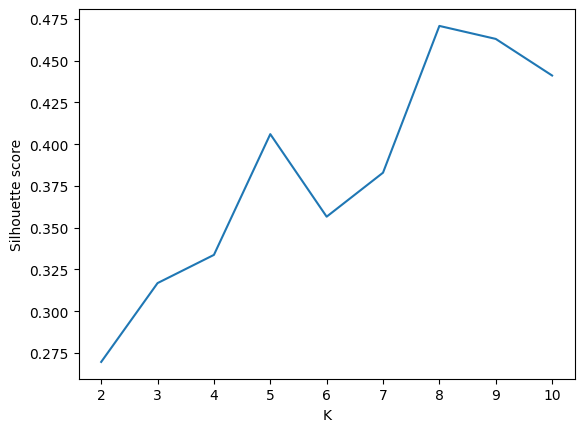

In [24]:
silhouettes = []

# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(processed_df)
    # Get the Silhouette score
    score = silhouette_score(processed_df, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score");


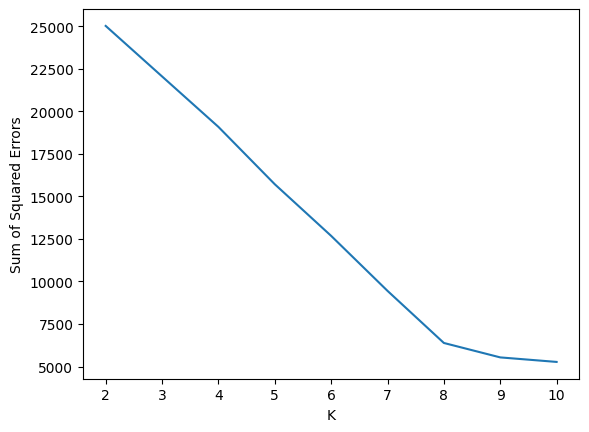

In [14]:
plot_sse(processed_df)

Both procedures suggest using K=8, indicating 8 clusters for our dataset. The silhouette score in the first plot reaches its highest value at K=8, and the second plot, which employs the elbow method, also shows a clear 'elbow' at the same value.

## Apply K-Means and use dimensionality reduction techniques for visualization

In [15]:
# Clustering with optimal k 
kmeans = KMeans(n_clusters=8,random_state=42)
processed_df['cluster'] = kmeans.fit_predict(processed_df)

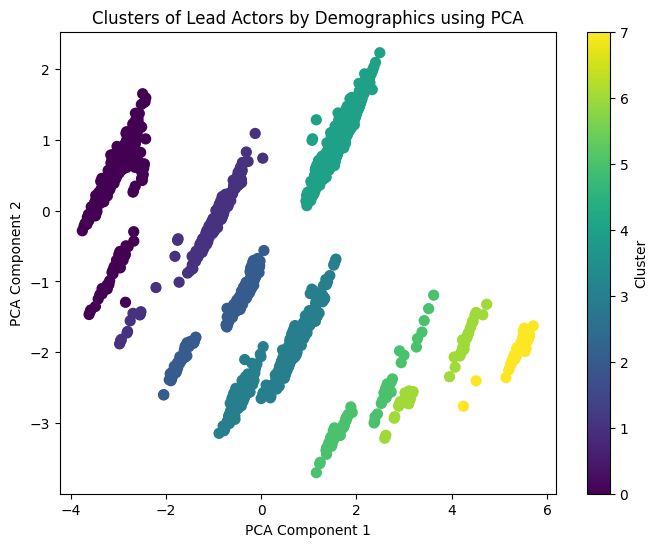

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(processed_df)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=processed_df['cluster'], s=50)
plt.colorbar(label='Cluster')
plt.title('Clusters of Lead Actors by Demographics using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

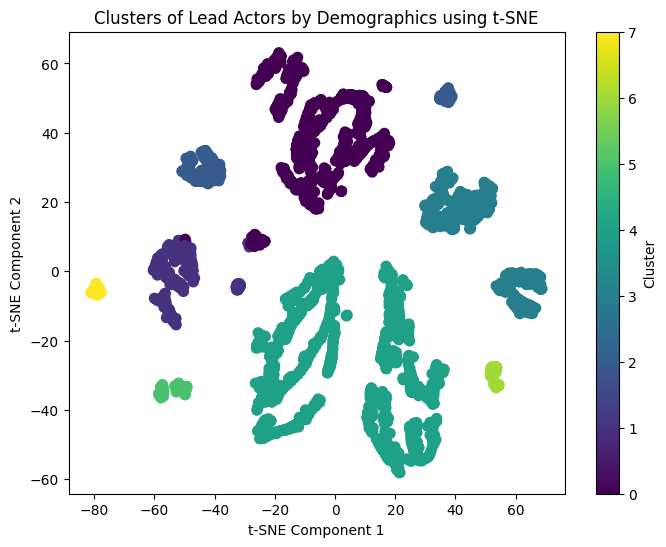

In [17]:
X_reduced_tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto').fit_transform(processed_df)
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=processed_df['cluster'],s=50)
plt.colorbar(label='Cluster')
plt.title('Clusters of Lead Actors by Demographics using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## What do this Clusters represent?

In [18]:
# Add cluster labels back to the original dataframe
cluster_df['cluster'] = processed_df['cluster']

cluster_summary = cluster_df.groupby('cluster').agg({
    'actor_height': ['mean', 'std'],
    'actor_age_at_release': ['mean', 'std'],
    'ethnicity_group': lambda x: x.mode()[0],  # extract most frequent value of column
    'actor_gender': lambda x: x.value_counts(normalize=True)# Proportions of each category
}).reset_index()

print(cluster_summary)


  cluster actor_height           actor_age_at_release             \
                  mean       std                 mean        std   
0       0     1.678274  0.064307            32.737772  10.555483   
1       1     1.817911  0.076520            37.145669  10.993640   
2       2     1.750198  0.085898            33.192090  10.050856   
3       3     1.725785  0.081132            35.155814  12.646951   
4       4     1.812071  0.065946            40.280033  12.467648   
5       5     1.689910  0.088338            33.164179  11.046180   
6       6     1.776224  0.087171            35.693878   9.897820   
7       7     1.803371  0.048956            35.085714   7.804114   

  ethnicity_group                                 actor_gender  
         <lambda>                                     <lambda>  
0        European   [0.9714673913043478, 0.028532608695652172]  
1         African    [0.9291338582677166, 0.07086614173228346]  
2           Asian    [0.7570621468926554, 0.242937853107344

### Cluster Actor Demographics

Below is a summary of the key actor demographics for each cluster, including height, age at the time of the movie's release, ethnicity, and gender.

#### Cluster 0:
- **Average Height**: 1.68 m (Std: 0.06)
- **Average Age at Release**: 32.74 years (Std: 10.56)
- **Ethnicity**: Predominantly European
- **Gender**: Female

#### Cluster 1:
- **Average Height**: 1.82 m (Std: 0.08)
- **Average Age at Release**: 37.15 years (Std: 10.99)
- **Ethnicity**: Predominantly African
- **Gender**: Male

#### Cluster 2:
- **Average Height**: 1.75 m (Std: 0.09)
- **Average Age at Release**: 33.19 years (Std: 10.05)
- **Ethnicity**: Predominantly Asian
- **Gender**: Male

#### Cluster 3:
- **Average Height**: 1.73 m (Std: 0.08)
- **Average Age at Release**: 35.16 years (Std: 12.65)
- **Ethnicity**: Predominantly Jewish
- **Gender**: Male

#### Cluster 4:
- **Average Height**: 1.81 m (Std: 0.07)
- **Average Age at Release**: 40.28 years (Std: 12.47)
- **Ethnicity**: Predominantly European
- **Gender**: Male

#### Cluster 5:
- **Average Height**: 1.69 m (Std: 0.09)
- **Average Age at Release**: 33.16 years (Std: 11.05)
- **Ethnicity**: Predominantly Latin American
- **Gender**: Female

#### Cluster 6:
- **Average Height**: 1.78 m (Std: 0.09)
- **Average Age at Release**: 35.69 years (Std: 9.90)
- **Ethnicity**: Predominantly Indigenous
- **Gender**: Male

#### Cluster 7:
- **Average Height**: 1.80 m (Std: 0.05)
- **Average Age at Release**: 35.09 years (Std: 7.80)
- **Ethnicity**: Predominantly Oceanian
- **Gender**: Male


## How does the 'adjusted_box_office' vary between different clusters?

In [19]:
merged_actors_movies['cluster'] = processed_df['cluster']
# Compute box office statistics per cluster
box_office_stats = merged_actors_movies.groupby('cluster').agg(
    mean_box_office=('adjusted_box_office', 'mean'),
    median_box_office=('adjusted_box_office', 'median'),
    std_box_office=('adjusted_box_office', 'std'),
    movie_count=('adjusted_box_office', 'count')  # Total number of movies in each cluster
).reset_index()

# Add a log-transformed mean for easier interpretation
box_office_stats['log_mean_box_office'] = np.log1p(box_office_stats['mean_box_office'])

# Display the summary statistics
print(box_office_stats)


   cluster  mean_box_office  median_box_office  std_box_office  movie_count  \
0      0.0     8.404055e+07       3.470471e+07    1.361221e+08          736   
1      1.0     7.452350e+07       3.235093e+07    1.247159e+08          254   
2      2.0     2.546125e+07       1.054591e+07    4.769423e+07          177   
3      3.0     8.222126e+07       3.641479e+07    1.237989e+08          430   
4      4.0     1.048202e+08       4.412434e+07    1.604223e+08         1207   
5      5.0     6.020901e+07       3.672699e+07    8.498261e+07           67   
6      6.0     5.173353e+07       3.405693e+07    9.052686e+07           49   
7      7.0     1.911701e+08       9.245703e+07    2.828152e+08           35   

   log_mean_box_office  
0            18.246810  
1            18.126625  
2            17.052668  
3            18.224925  
4            18.467757  
5            17.913333  
6            17.761617  
7            19.068674  


### Cluster Box office Summary

Here is an overview of the key statistics and insights for each cluster based on their box office revenue:

#### Cluster 0:
- **Mean Revenue**: 112.76 million dollar
- **Median Revenue**: 46.56 million dollar
- **Observation**: The high mean indicate a significant number of commercially successful movies. The high standard deviation (182.64 million dollar) suggests variability, with some extreme box office hits.

#### Cluster 1:
- **Mean Revenue**: 99.99 million dollar
- **Median Revenue**: 43.41 million dollar
- **Observation**: Movies in this cluster are less successfull than in cluster 0. A standard deviation of 167.33 million dollar shows some variability.

#### Cluster 2:
- **Mean Revenue**: 34.16 million dollar
- **Median Revenue**: 14.15 million dollar
- **Observation**: This cluster underperforms compared to others, with lower average and median revenues. It likely includes niche or lower-budget films.

#### Cluster 3:
- **Mean Revenue**: 110.32 million dollar
- **Median Revenue**: 48.86 million dollar
- **Observation**: Similar to Cluster 0, this cluster shows consistent performance. A standard deviation of 166.10 million dollar indicates fewer extreme values than Cluster 0.

#### Cluster 4:
- **Mean Revenue**: 140.64 million dollar
- **Median Revenue**: 59.20 million dollar
- **Observation**: The cluster is very sucessfull with a high mean and median revenue, possibly including blockbuster films. A standard deviation of 215.24 million dollar indicates significant variability.

#### Cluster 5:
- **Mean Revenue**: 80.78 million dollar
- **Median Revenue**: 49.28 million dollar
- **Observation**: A smaller cluster with fewer movies (67). Movies here have moderate success on average.

#### Cluster 6:
- **Mean Revenue**: 69.41 million dollar
- **Median Revenue**: 45.69 million dollar
- **Observation**: A small cluster (49 movies) with modest box office revenue compared to other clusters.

#### Cluster 7:
- **Mean Revenue**: 256.49 million dollar
- **Median Revenue**: 124.05 million dollar
- **Observation**: This cluster has the highest mean and median revenue, indicating highly successful or blockbuster movies. Despite having only 35 movies, this cluster outperforms others.


In [20]:
from scipy.stats import f_oneway, kruskal

# Extract box office revenues for each cluster
cluster_revenues = [merged_actors_movies[merged_actors_movies['cluster'] == i]['adjusted_box_office'] for i in range(8)]

# Perform ANOVA
anova_result = f_oneway(*cluster_revenues)
print(f"ANOVA p-value: {anova_result.pvalue}")

# Perform Kruskal-Wallis test
kruskal_result = kruskal(*cluster_revenues)
print(f"Kruskal-Wallis p-value: {kruskal_result.pvalue}")

ANOVA p-value: 2.8546805208509616e-14
Kruskal-Wallis p-value: 1.3797312292809242e-24


## Conclusion

The analysis of the actor demographics and box office performance across the clusters reveals interesting patterns:

1. **Actor Demographics**:  
   - Clusters show diverse actor characteristics such as height, age at release, ethnicity, and gender. For example, Cluster 0 is dominated by female European actors with an average age of 32.74 years, while Cluster 1 features male African actors with a higher average age of 37.15 years. Other clusters similarly reflect distinct demographic trends, suggesting that the type of movies in each cluster may be associated with particular actor profiles.

2. **Box Office Performance**:  
   - The clusters show significant variation in box office revenues. Cluster 4 stands out with the highest total revenue, average revenue, and median, indicating that this cluster likely includes blockbuster movies. Conversely, Cluster 2 has the lowest average and median box office earnings, suggesting the presence of niche or lower-budget films.
   - Notable patterns include Cluster 7, with a smaller number of movies but very high per-movie revenue, suggesting that these films are highly successful, possibly blockbusters.

3. **Statistical Tests**:  
   - Both the ANOVA and Kruskal-Wallis tests yield extremely low p-values, indicating significant differences in box office performance across the clusters.

### Limitations

- **Demographic Representation**: The actor demographics and ethnicity breakdown may not fully capture all cultural or contextual influences in the box office performance. There may be other unobserved factors affecting revenue, such as the genre or marketing budget.
- **Cluster Interpretations**: The clusters were formed using unsupervised methods, which can sometimes obscure deeper, more meaningful groupings. The demographic and box office patterns found here are based on the assumption that the clustering algorithm identifies meaningful segments.
- **Generalization**: The conclusions drawn from these clusters may not apply universally across all films, especially in different cultural or market contexts. The sample size for some clusters (e.g., Cluster 7 with only 35 movies) may be too small to draw definitive conclusions.
- **Ethnicity Influence**: As seen in the results, the clusters were primarily formed using manually grouped ethnicities for clustering, as each cluster has a different ethnicity as the most frequent value. This could introduce bias or skew the results, as the ethnicities might be overrepresented or underrepresented in certain clusters.
- **Variation in Lead Actors**: There is a large difference in the number of lead actors across the clusters, which could affect the box office statistics. The smaller clusters with fewer lead actors may not have enough data to accurately represent the box office performance of related to lead actors' characteristics.
